# Installing some missing packages (quiet mode)

In [2]:
#
# Install missing modules (no echo)
#
!pip install -q seaborn
!pip install -q missingno
!pip install -q scikit-learn

# Importing the necessary modules (TensorFlow and others)

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as missing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Exploratory Data Analysis 

Loading data

In [4]:
df = pd.read_csv('measurements.csv')
print('Data has {} rows, each row has {} entries'.format(*df.shape))

Data has 1330816 rows, each row has 13 entries


In [5]:
df.head(10)

u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   
5 -0.538973  18.901548       19.077108  0.009147     18.290628     0.009636   
6 -0.653148  18.941711       19.074583  0.238890     18.292524     0.001337   
7 -0.758392  18.960861       19.082499  0.395099     18.294041     0.001422   
8 -0.727128  18.973545       19.085533  0.546623     18.291964     0.000577   
9 -0.874307  18.987812       19.076025  0.578944     18.287233    -0.001248   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197          17  
5 -0.613635  0.336747  24.573601    18.323862  19.850634  0.476218          17  
6 -1.005647  0.554211  24.576578    18.321936  19.850630  0.670015          17  
7 -1.288384  0.706370  24.574949    18.314655  19.850628  0.752035          17  
8 -1.490530  0.817339  24.567080    18.306925  19.850626  0.910541          17  
9 -1.634464  0.898013  24.553242    18.301733  19.850624  0.924010          17

Checking for missing entries

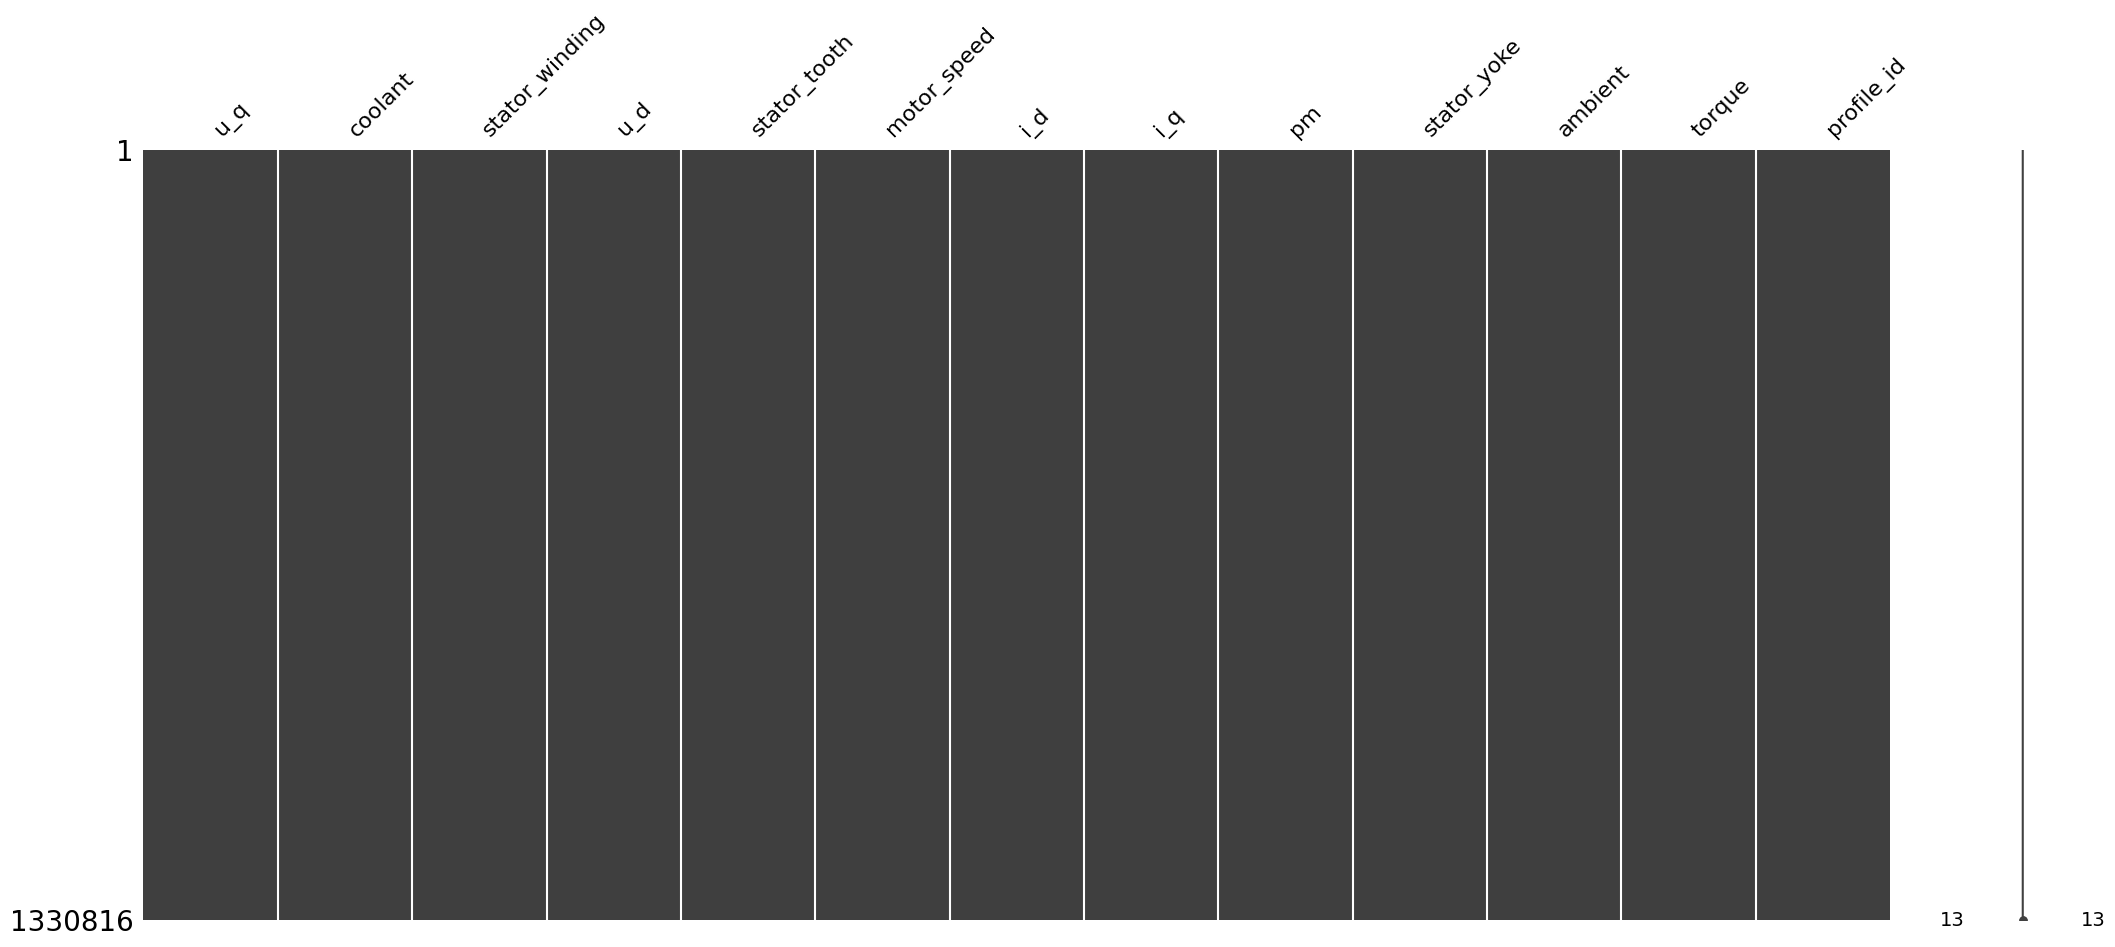

In [6]:
missing.matrix(df);

Checking for duplicates

In [7]:
print('Are there duplicated rows? {}'.format(df.duplicated().any()))

Are there duplicated rows? False


The correlation matrix of all available features

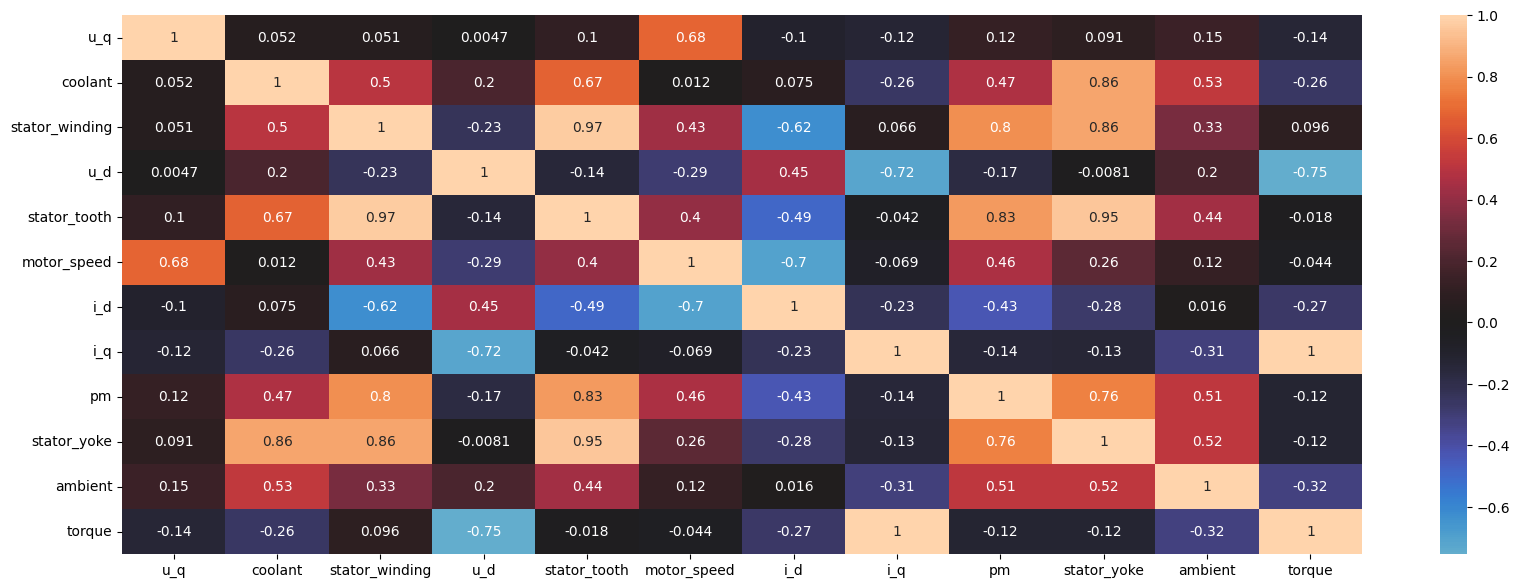

In [8]:
cor = df.drop(columns=['profile_id']).corr('pearson')
plt.rcParams["figure.figsize"] = (20, 7)
sns.heatmap(cor, annot = True, center=0);

From the above it is clear that "torque" correlates very stringly with "i_q". It also has some correlation with other features ("u_d", "i_d"). Thus, predicting the motor torque alone may require a simpler model. 

Defining features and non-features

In [9]:
features_init = ['ambient', 'coolant', 'u_d', 'u_q', 'i_d', 'i_q']
non_features_init = [c for c in df.columns if not(c in features_init)]

Defining features

In [10]:
df[features_init].describe()

ambient       coolant           u_d           u_q           i_d  \
count  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06   
mean   2.456526e+01  3.622999e+01 -2.513381e+01  5.427900e+01 -6.871681e+01   
std    1.929522e+00  2.178615e+01  6.309197e+01  4.417323e+01  6.493323e+01   
min    8.783478e+00  1.062375e+01 -1.315304e+02 -2.529093e+01 -2.780036e+02   
25%    2.318480e+01  1.869814e+01 -7.869090e+01  1.206992e+01 -1.154061e+02   
50%    2.479733e+01  2.690014e+01 -7.429755e+00  4.893818e+01 -5.109376e+01   
75%    2.621702e+01  4.985749e+01  1.470271e+00  9.003439e+01 -2.979688e+00   
max    3.071420e+01  1.015985e+02  1.314698e+02  1.330370e+02  5.189670e-02   

                i_q  
count  1.330816e+06  
mean   3.741278e+01  
std    9.218188e+01  
min   -2.934268e+02  
25%    1.095863e+00  
50%    1.577401e+01  
75%    1.006121e+02  
max    3.017079e+02

Correlation matrix for possible input features

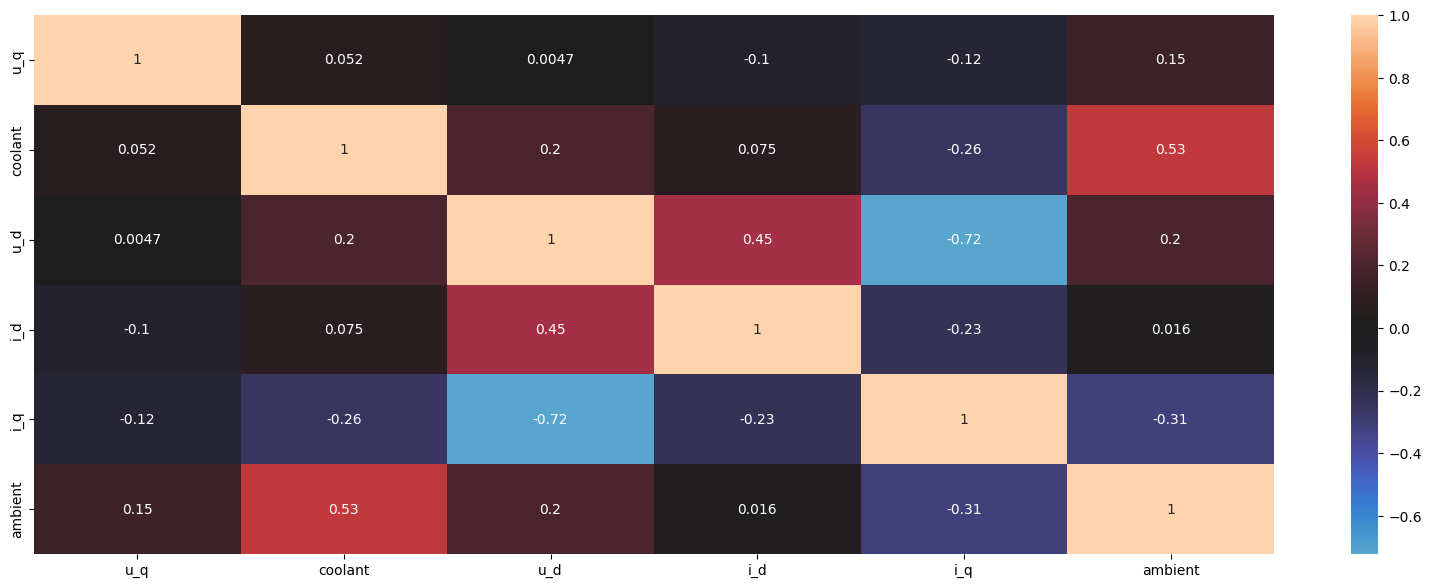

In [11]:
cor = df.drop(columns=non_features_init).corr('pearson')
plt.rcParams["figure.figsize"] = (20, 7)
sns.heatmap(cor, annot = True, center=0);

Making new physics-informed features: voltage and current amplitudes

In [12]:
def amplitude(x, y):
    return np.sqrt(x**2 + y**2)

In [13]:
df['u_a'] = df.apply(lambda row: amplitude(row['u_d'], row['u_q']), axis=1)
df['i_a'] = df.apply(lambda row: amplitude(row['i_d'], row['i_q']), axis=1)

In [14]:
features_init = ['ambient', 'coolant', 'u_d', 'u_q', 'i_d', 'i_q', 'u_a', 'i_a']
non_features_init = [c for c in df.columns if not(c in features_init)]

Looking up the correlation matrix again : I have 8 features to choose from, and want to choose less than 6

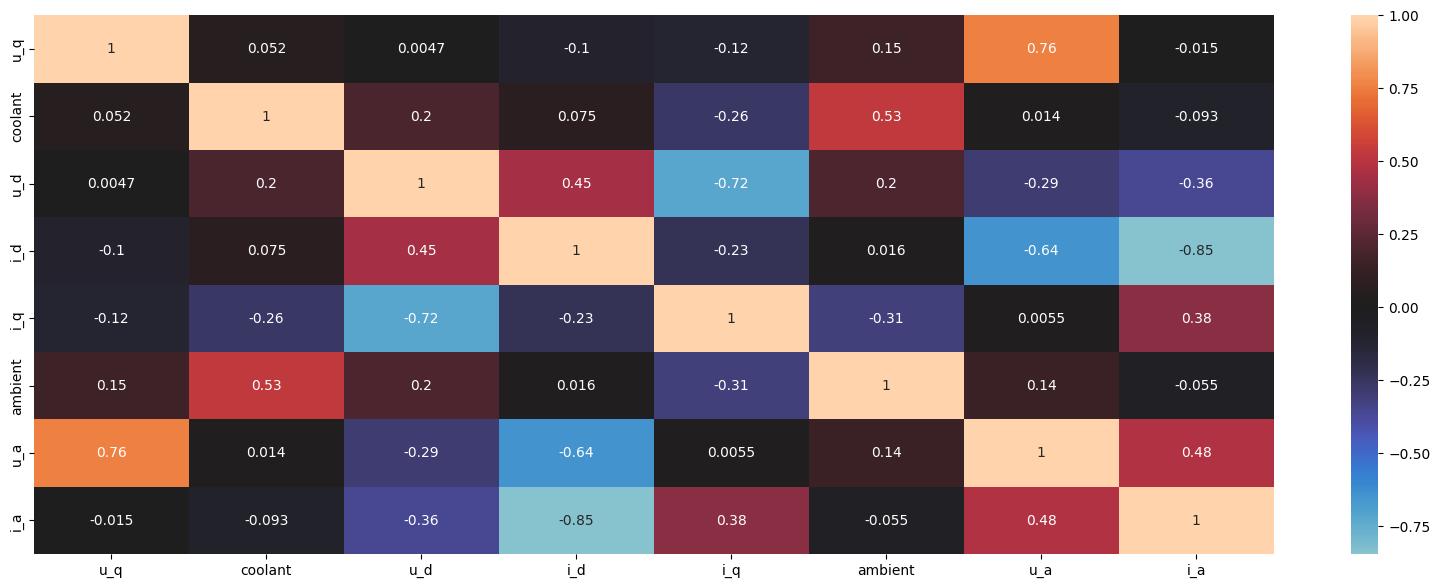

In [15]:
cor = df.drop(columns=non_features_init).corr('pearson')
plt.rcParams["figure.figsize"] = (20, 7)
sns.heatmap(cor, annot = True, center=0);

We want to remove those that are visibly correlated (abs(correlation) > 0.6) with some others : motor_speed, i_d, i_q

I assume that the ambient and coolant temperatures are relatively easy to measure in a working engine

Also voltages and currents should be measurable in a reliable way

In [16]:
features = ['ambient', 'coolant', 'u_d', 'u_q', 'u_a', 'i_a']
non_features = [c for c in df.columns if not(c in features)]

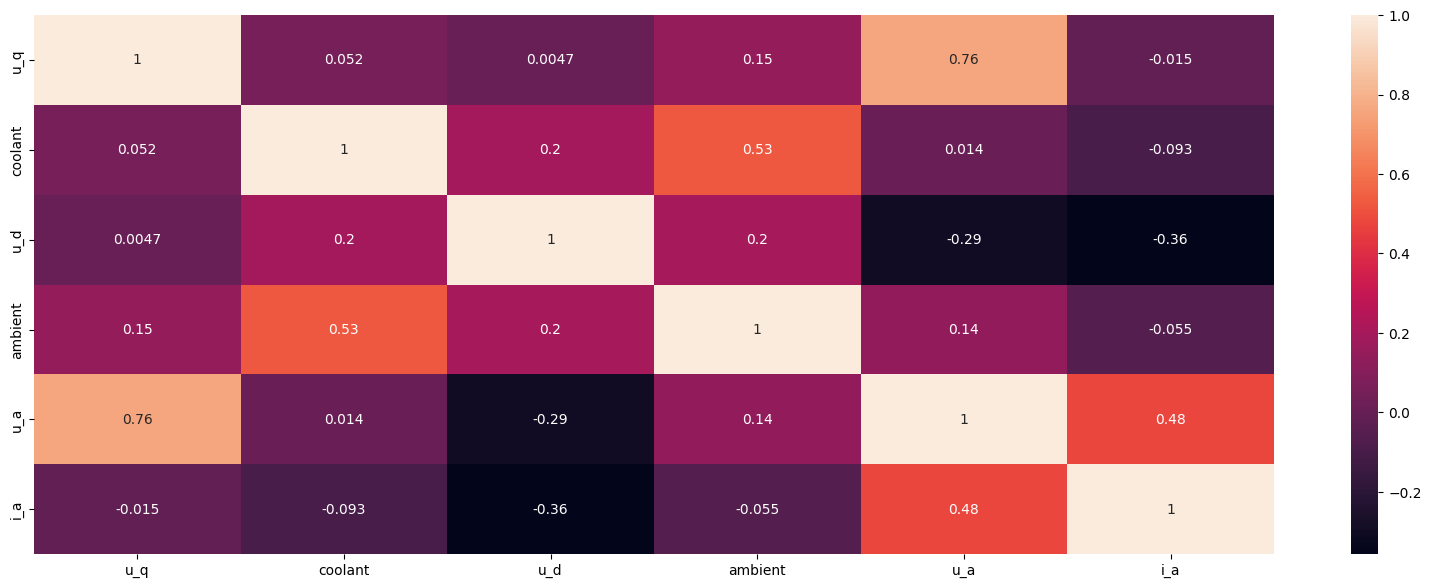

In [17]:
cor = df.drop(columns=non_features).corr('pearson')
plt.rcParams["figure.figsize"] = (20, 7)
sns.heatmap(cor, annot = True);

The voltage amplitude can be also excluded, and we keep the u_d / u_q pair instead

However for currents the amplitude seems to be enough already (the physical intuition being, that is what generates heat)

Finally, after employing some correlation analysis and physics intuition, I have 5 input features

In [18]:
features = ['ambient', 'coolant', 'u_d', 'u_q', 'i_a']
non_features = [c for c in df.columns if not(c in features)]

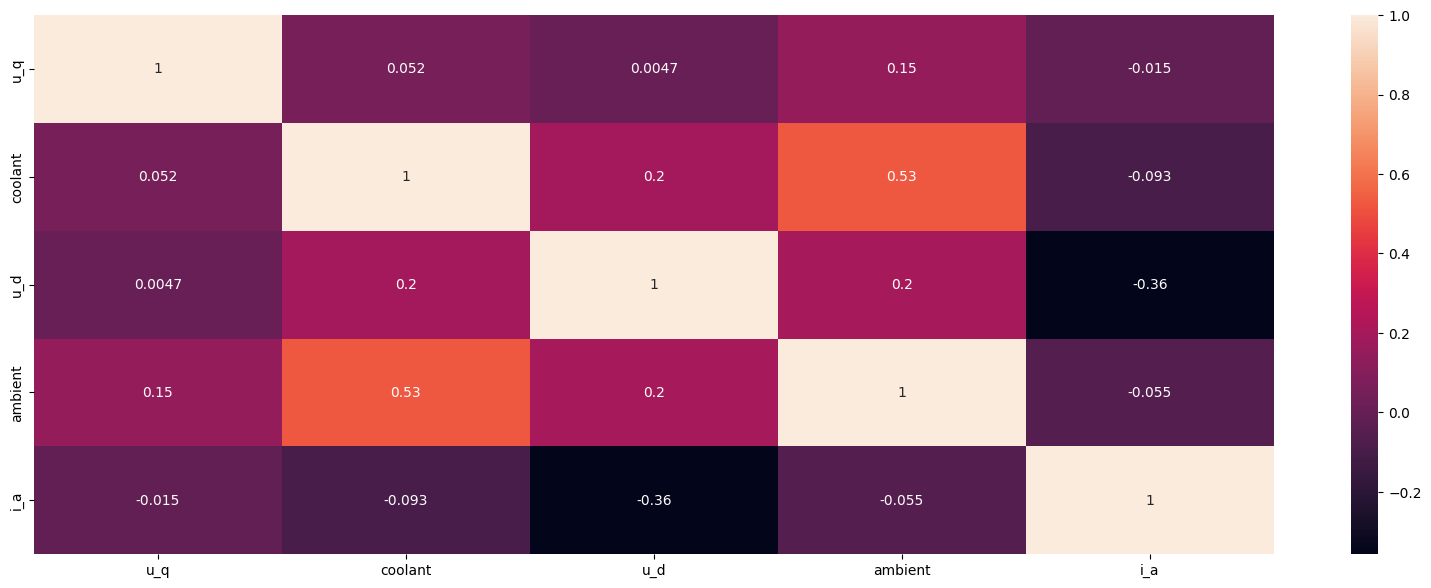

In [19]:
cor = df.drop(columns=non_features, axis=1).corr('pearson')
plt.rcParams["figure.figsize"] = (20, 7)
sns.heatmap(cor, annot = True);

Now we see that our input features are not stringly correlated. Most correlated are the ambient and coolant temperature, and I keep them both since the correlation coefficient is not that big (abs < 0.6), and both features are physics-informed and provide some baseline for heat distribution and transfer

The most interesting target features are rotor temperature ("pm"), stator temperatures ("stator_*") and torque.
Especially rotor temperature and torque are not reliably and economically measurable in a commercial vehicle. (Source: https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature)

I will also add "motor_speed" to the output list (this one should be very well predictable)

In [20]:
output = ['pm', 'stator_winding', 'stator_tooth', 'stator_yoke', 'motor_speed', 'torque']

Let me check how well the outputs are correlated. It is clearly visible (and expected) that all temperatures are strongly correlated (so in a sense I'm gonna predict 1 feature instead of 4). The motor speed is somewhat correlated with the temperatures, while the motor torque is not (also physically explainable, as the speed is affecting the motors heat production, while the torque can be the same for a motor that just started and for a motor that has worked enough to heat up)

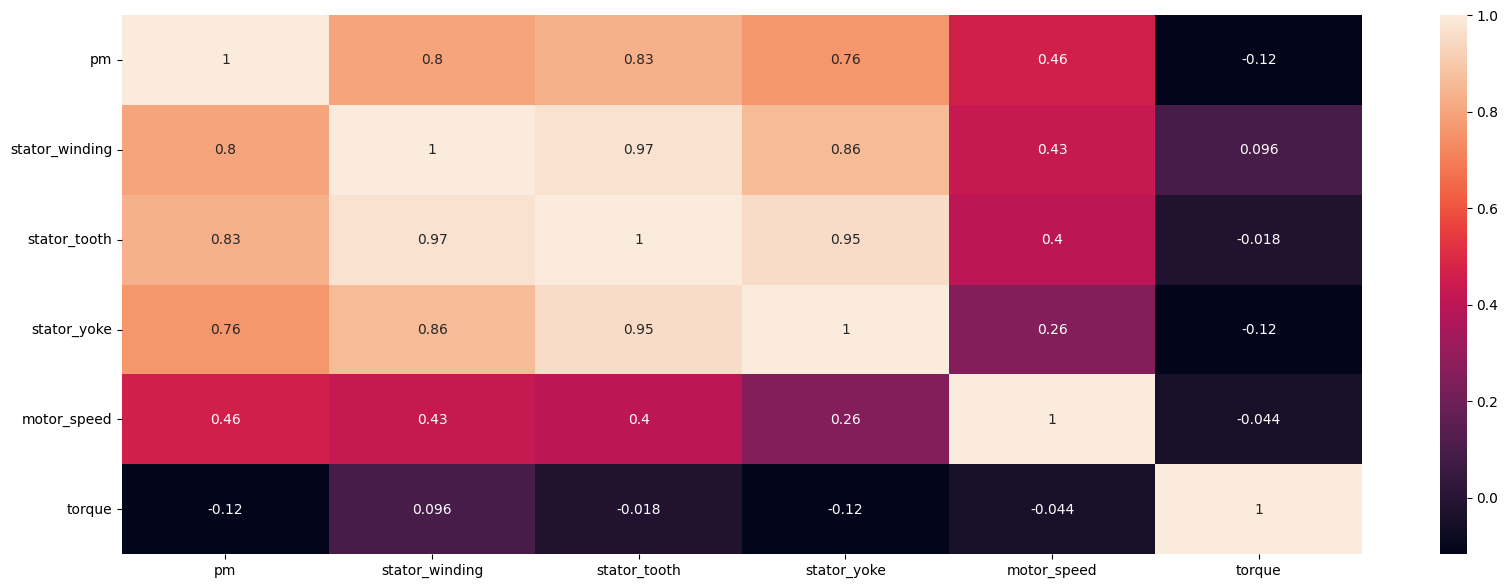

In [21]:
cor = df[output].corr('pearson')
plt.rcParams["figure.figsize"] = (20, 7)
sns.heatmap(cor, annot = True);

Defining our input and output features

In [22]:
X = df[features]
y = df[output]

In [23]:
X.describe()

ambient       coolant           u_d           u_q           i_a
count  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06
mean   2.456526e+01  3.622999e+01 -2.513381e+01  5.427900e+01  1.075446e+02
std    1.929522e+00  2.178615e+01  6.309197e+01  4.417323e+01  8.526254e+01
min    8.783478e+00  1.062375e+01 -1.315304e+02 -2.529093e+01  3.922213e-05
25%    2.318480e+01  1.869814e+01 -7.869090e+01  1.206992e+01  1.182819e+01
50%    2.479733e+01  2.690014e+01 -7.429755e+00  4.893818e+01  1.106200e+02
75%    2.621702e+01  4.985749e+01  1.470271e+00  9.003439e+01  1.721419e+02
max    3.071420e+01  1.015985e+02  1.314698e+02  1.330370e+02  3.615153e+02

In [24]:
y.describe()

pm  stator_winding  stator_tooth   stator_yoke   motor_speed  \
count  1.330816e+06    1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06   
mean   5.850678e+01    6.634275e+01  5.687858e+01  4.818796e+01  2.202081e+03   
std    1.900150e+01    2.867206e+01  2.295223e+01  1.999100e+01  1.859663e+03   
min    2.085696e+01    1.858582e+01  1.813398e+01  1.807669e+01 -2.755491e+02   
25%    4.315158e+01    4.278796e+01  3.841601e+01  3.199033e+01  3.171107e+02   
50%    6.026629e+01    6.511013e+01  5.603635e+01  4.562551e+01  1.999977e+03   
75%    7.200837e+01    8.814114e+01  7.558668e+01  6.146083e+01  3.760639e+03   
max    1.136066e+02    1.413629e+02  1.119464e+02  1.011480e+02  6.000015e+03   

             torque  
count  1.330816e+06  
mean   3.110603e+01  
std    7.713575e+01  
min   -2.464667e+02  
25%   -1.374265e-01  
50%    1.086035e+01  
75%    9.159718e+01  
max    2.610057e+02

Different features have different mean and std, sometimes varying by several orders of magnitude. I don't like this, and thus I will scale each of the features with StandardScaler. Then I will group the data based on "profile_id" in order to obtain time series.

In [25]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = pd.DataFrame(scaler_X.fit_transform(X), columns=list(X.columns))
y = pd.DataFrame(scaler_y.fit_transform(y), columns=list(y.columns))

data = pd.concat([X, y, df['profile_id']], axis=1)
data_grouped = {group_id: group_df for group_id, group_df in data.groupby('profile_id')}

In [26]:
X.describe()

ambient       coolant           u_d           u_q           i_a
count  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06
mean   5.821298e-15  1.027680e-15 -7.756718e-17  7.553403e-16  5.655229e-16
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min   -8.179116e+00 -1.175346e+00 -1.686374e+00 -1.801316e+00 -1.261334e+00
25%   -7.154374e-01 -8.047253e-01 -8.488737e-01 -9.555356e-01 -1.122608e+00
50%    1.202738e-01 -4.282472e-01  2.806072e-01 -1.209064e-01  3.607026e-02
75%    8.560482e-01  6.255120e-01  4.216716e-01  8.094359e-01  7.576286e-01
max    3.186775e+00  3.000463e+00  2.482149e+00  1.782935e+00  2.978692e+00

In [27]:
y.describe()

pm  stator_winding  stator_tooth   stator_yoke   motor_speed  \
count  1.330816e+06    1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06   
mean  -7.338129e-16   -1.998893e-15  1.236462e-15 -6.019145e-16  4.073131e-16   
std    1.000000e+00    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.981414e+00   -1.665627e+00 -1.688055e+00 -1.506242e+00 -1.332301e+00   
25%   -8.081047e-01   -8.215244e-01 -8.043913e-01 -8.102463e-01 -1.013609e+00   
50%    9.259859e-02   -4.299018e-02 -3.669520e-02 -1.281805e-01 -1.086778e-01   
75%    7.105545e-01    7.602662e-01  8.150887e-01  6.639420e-01  8.380866e-01   
max    2.899765e+00    2.616490e+00  2.399238e+00  2.649193e+00  2.042271e+00   

             torque  
count  1.330816e+06  
mean  -3.553739e-17  
std    1.000000e+00  
min   -3.598497e+00  
25%   -4.050452e-01  
50%   -2.624682e-01  
75%    7.842169e-01  
max    2.980456e+00

"profile_id" is not really a list of consecutive numbers (as unique id's) : this doesn't really matter though, we use it only for grouping the data

In [28]:
np.sort(np.array(df.get('profile_id').unique()))

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 23, 24, 26, 27, 29, 30, 31, 32, 36, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
       63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80,
       81])

Some data lookup : I don't get any insights from this one as everything is already normalized, just double checking

In [29]:
data_grouped[2].head(10)

ambient   coolant       u_d       u_q       i_a        pm  \
90975 -2.368578 -0.941539  0.399179 -1.117358 -1.261330 -1.860540   
90976 -2.389794 -0.933582  0.399554 -1.116751 -1.261309 -1.860554   
90977 -2.404996 -0.928913  0.399377 -1.116910 -1.261333 -1.860843   
90978 -2.415889 -0.922368  0.399584 -1.117370 -1.261313 -1.861492   
90979 -2.423694 -0.920980  0.399708 -1.117298 -1.261294 -1.861371   
90980 -2.429286 -0.925423  0.398823 -1.117119 -1.261298 -1.861390   
90981 -2.433293 -0.931874  0.399069 -1.117055 -1.261321 -1.860656   
90982 -2.436165 -0.936462  0.399107 -1.116683 -1.261182 -1.860537   
90983 -2.438222 -0.940850  0.405211 -1.121709 -1.253641 -1.860456   
90984 -2.423698 -0.943995  0.409713 -1.125584 -1.248237 -1.860654   

       stator_winding  stator_tooth  stator_yoke  motor_speed    torque  \
90975       -1.625749     -1.655142    -1.490315    -1.130375 -0.411113   
90976       -1.625457     -1.654862    -1.491245    -1.130346 -0.411212   
90977       -1.625348     -1.654559    -1.491482    -1.130356 -0.411237   
90978       -1.625809     -1.654327    -1.491320    -1.130367 -0.411269   
90979       -1.625702     -1.655719    -1.491136    -1.130343 -0.411127   
90980       -1.625659     -1.656628    -1.491040    -1.130354 -0.411300   
90981       -1.625998     -1.656600    -1.491072    -1.130376 -0.411188   
90982       -1.626274     -1.656154    -1.490958    -1.130343 -0.411117   
90983       -1.625867     -1.657331    -1.490883    -1.130350 -0.408475   
90984       -1.625911     -1.659747    -1.491621    -1.130364 -0.406289   

       profile_id  
90975           2  
90976           2  
90977           2  
90978           2  
90979           2  
90980           2  
90981           2  
90982           2  
90983           2  
90984           2

In [30]:
data_grouped[2].describe()

ambient       coolant           u_d           u_q           i_a  \
count  19357.000000  19357.000000  19357.000000  19357.000000  19357.000000   
mean      -1.241264     -0.811890      0.353744     -1.095336     -0.026584   
std        0.321985      0.015081      0.086770      0.050525      1.535488   
min       -2.525368     -0.947168      0.242714     -1.140044     -1.261333   
25%       -1.362354     -0.820540      0.243040     -1.134998     -1.234577   
50%       -1.171878     -0.812623      0.421641     -1.134259     -1.234564   
75%       -1.064871     -0.804399      0.422089     -1.030748      1.926815   
max       -0.608277     -0.755313      0.425330     -1.029594      1.926833   

                 pm  stator_winding  stator_tooth   stator_yoke   motor_speed  \
count  19357.000000    19357.000000  19357.000000  19357.000000  19357.000000   
mean      -1.355008       -0.531266     -0.774310     -0.827637     -1.130356   
std        0.397026        1.324590      1.045436      0.759535      0.000014   
min       -1.870188       -1.636226     -1.666929     -1.495080     -1.130667   
25%       -1.729091       -1.625959     -1.644511     -1.459389     -1.130365   
50%       -1.434314       -1.620461     -1.613262     -1.422830     -1.130356   
75%       -0.983925        1.235303      0.621081      0.188985     -1.130347   
max       -0.658960        1.288355      0.664125      0.220837     -1.130059   

             torque  profile_id  
count  19357.000000     19357.0  
mean       0.622832         2.0  
std        1.300345         0.0  
min       -0.411300         2.0  
25%       -0.400164         2.0  
50%       -0.399967         2.0  
75%        2.273037         2.0  
max        2.297049         2.0

Each group has its own number of records

In [31]:
sizes = [group_df.shape[0] for group_id, group_df in data_grouped.items()]
print("Group sizes:")
print(np.sort(sizes))
max_len_group, min_len_group = np.max(sizes), np.min(sizes)
print('Max group has {} records, and min group has {} records'.format(max_len_group, min_len_group))

Group sizes:
[ 2176  2180  3726  6250  6261  7475  7887  8443  8445 10410 10807 10807
 10810 10816 11135 11856 13472 14403 14516 14543 14651 14656 14788 15015
 15256 15301 15350 15587 15964 16666 16668 16700 16786 16920 17142 17321
 17672 18124 18598 18757 19248 19357 20336 20645 20960 21358 21942 21983
 22188 22609 23331 23761 23824 23863 25600 25677 26341 31154 32442 33123
 33382 33424 35361 35906 36476 37732 40094 40388 43971]
Max group has 43971 records, and min group has 2176 records


Plotting all timeseries for "pm" (not very informative, just to show that different "profile_id" gives very different series

In [32]:
#
# Plotting feature "f" from "data_grouped" data frame
#
def plot_all(data_grouped, f):
    axes = []
    for group_id, group_df in data_grouped.items():
        group_df.index = np.arange(len(group_df))
        axes += [group_df[f].plot()]
    axes[-1].set_title(f)
    plt.show()

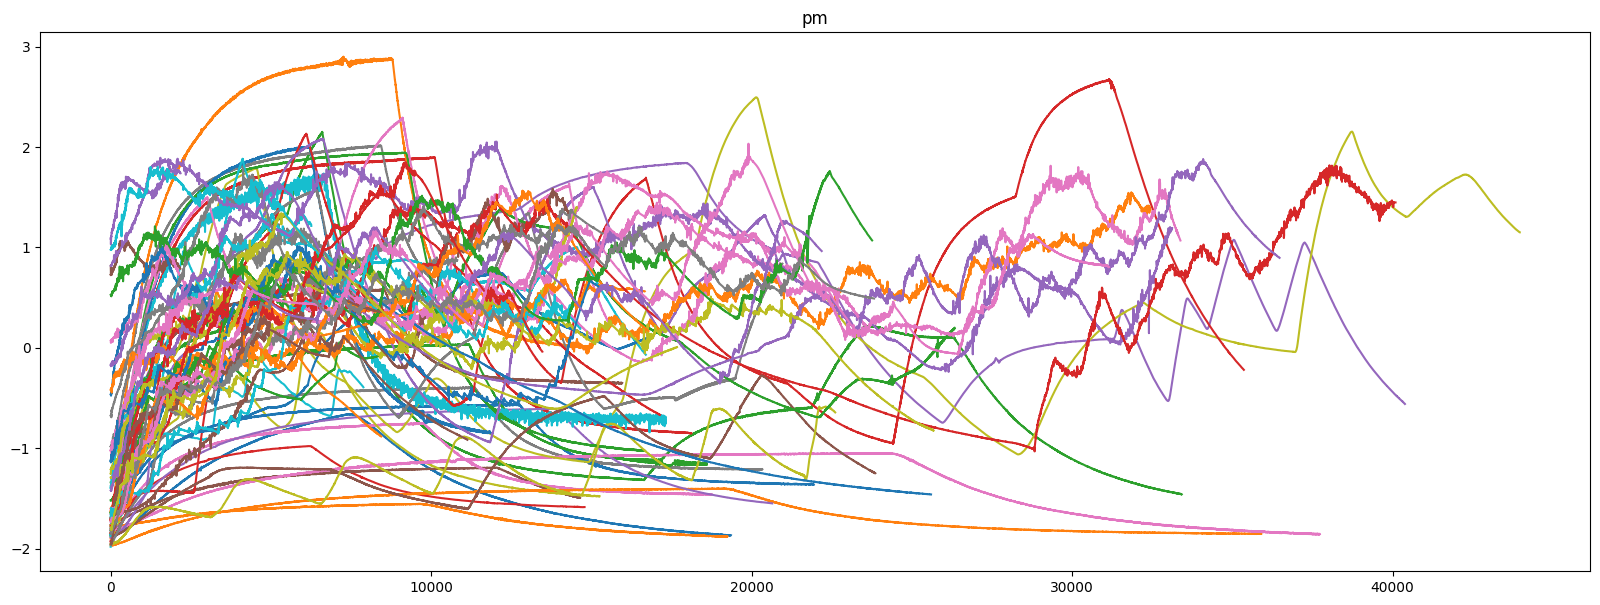

In [33]:
plot_all(data_grouped, 'pm')

Same for "stator_yoke"

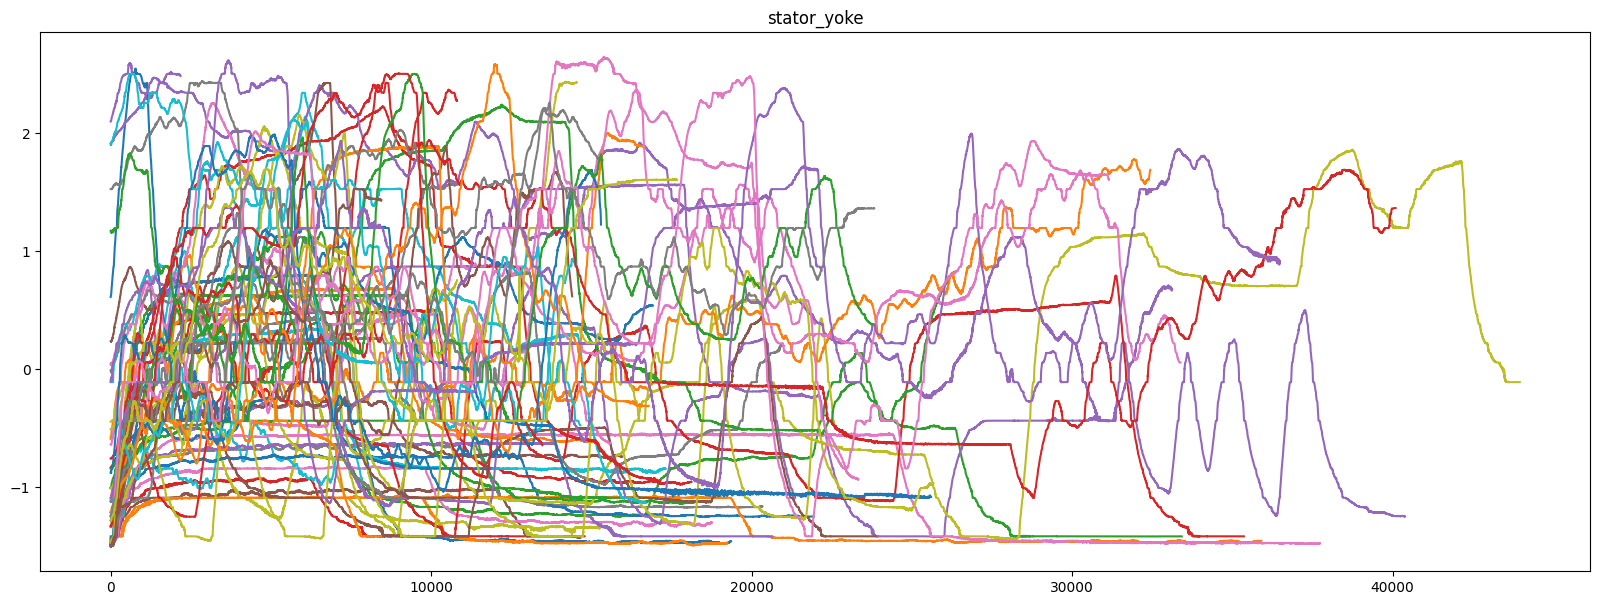

In [34]:
plot_all(data_grouped, 'stator_yoke')

The values of "torque" and "motor_speed" are even messier : here I'm plotting already normalised values, but centering / rescaling doesn't really change the general optics of it. Here everything depends on the driving mode, from somewhat regular to outright chaotic

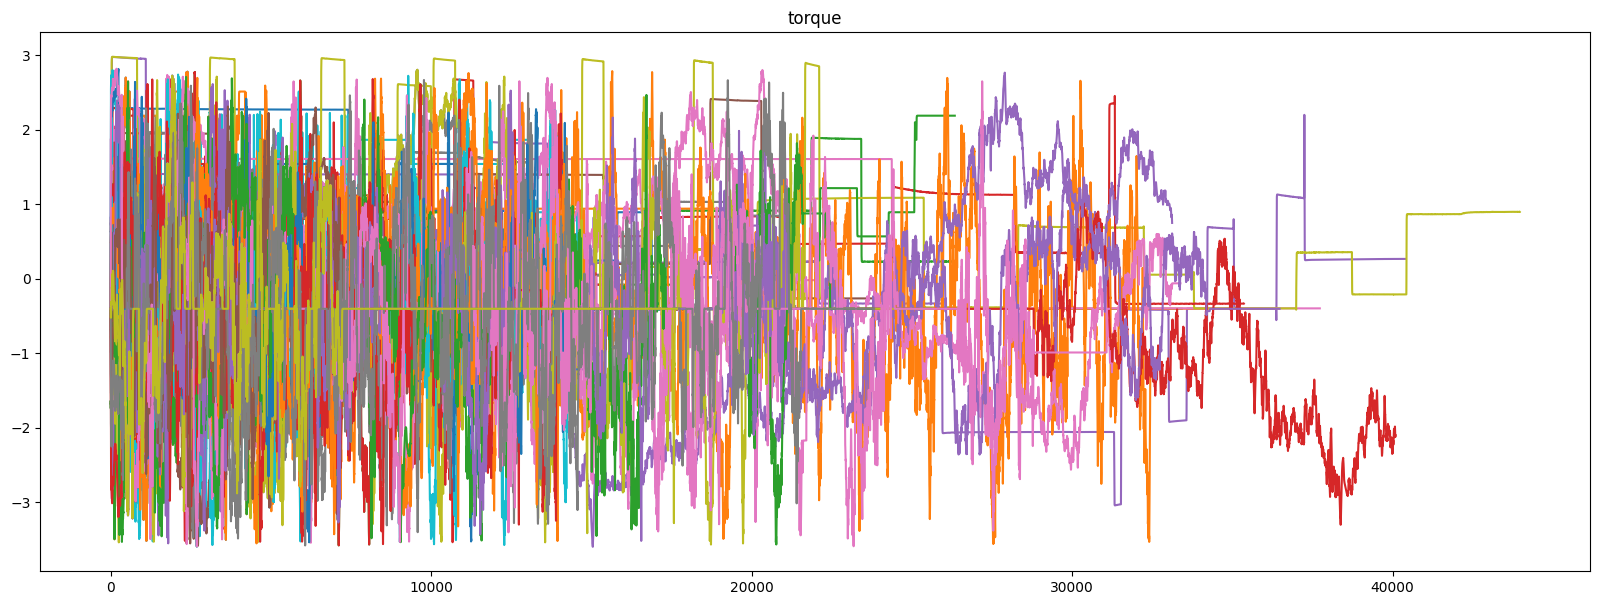

In [35]:
plot_all(data_grouped, 'torque')

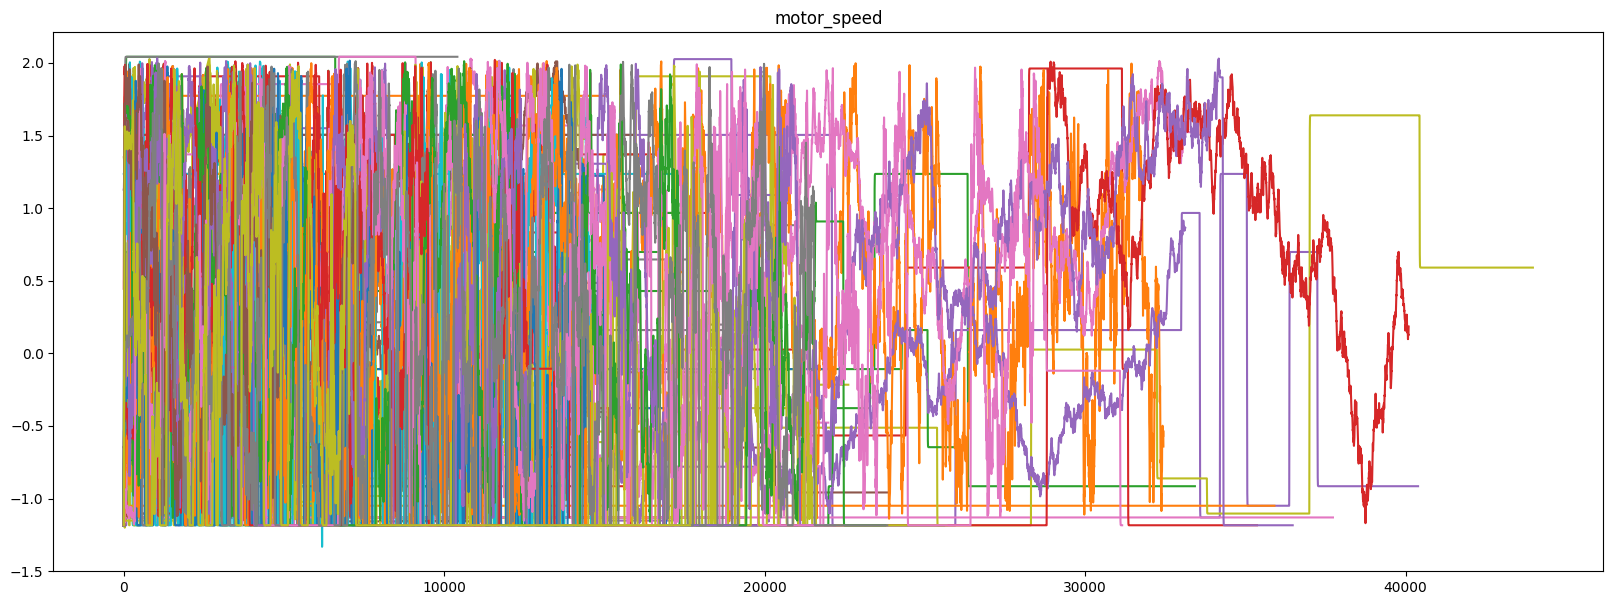

In [36]:
plot_all(data_grouped, 'motor_speed')

For the input features we don't have much better behavior: "ambient" and "coolant" are more continuous (as they are temperatures satisfying from the heat flow equation, and their spikes are likely due to noise / measurement error)

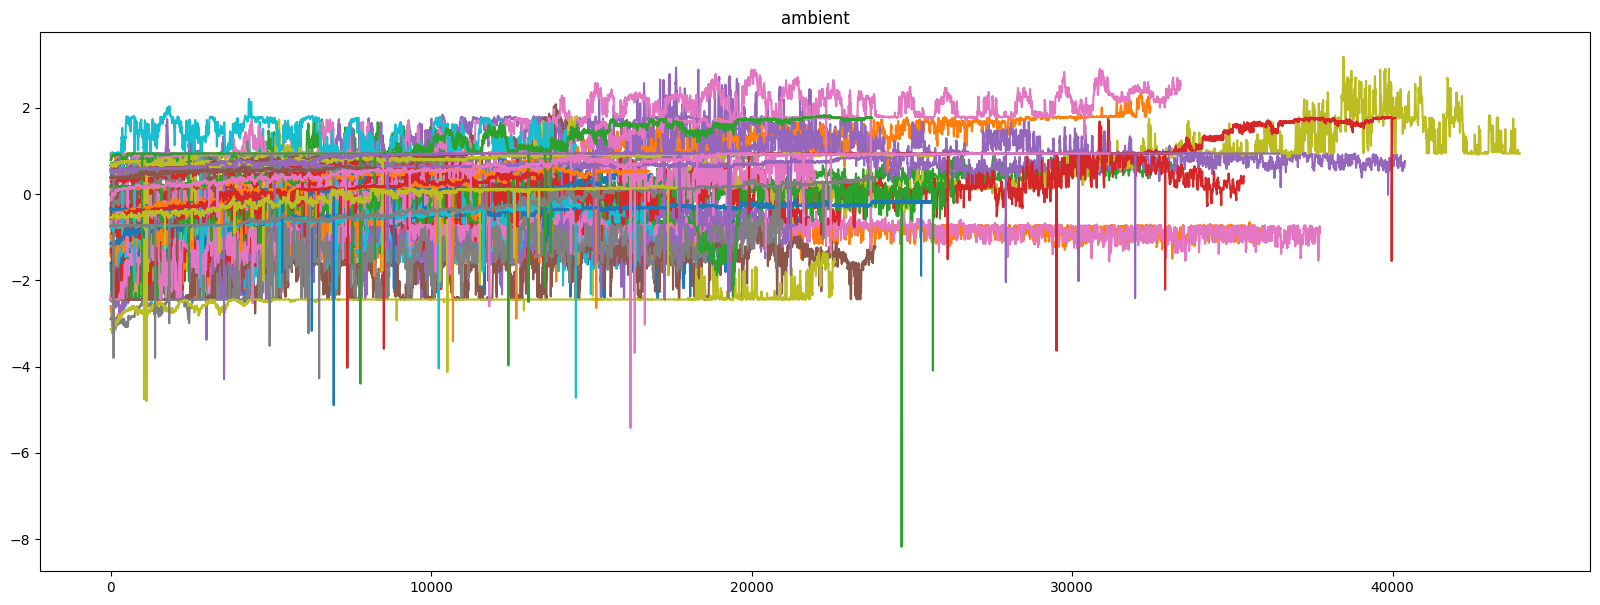

In [37]:
plot_all(data_grouped, 'ambient')

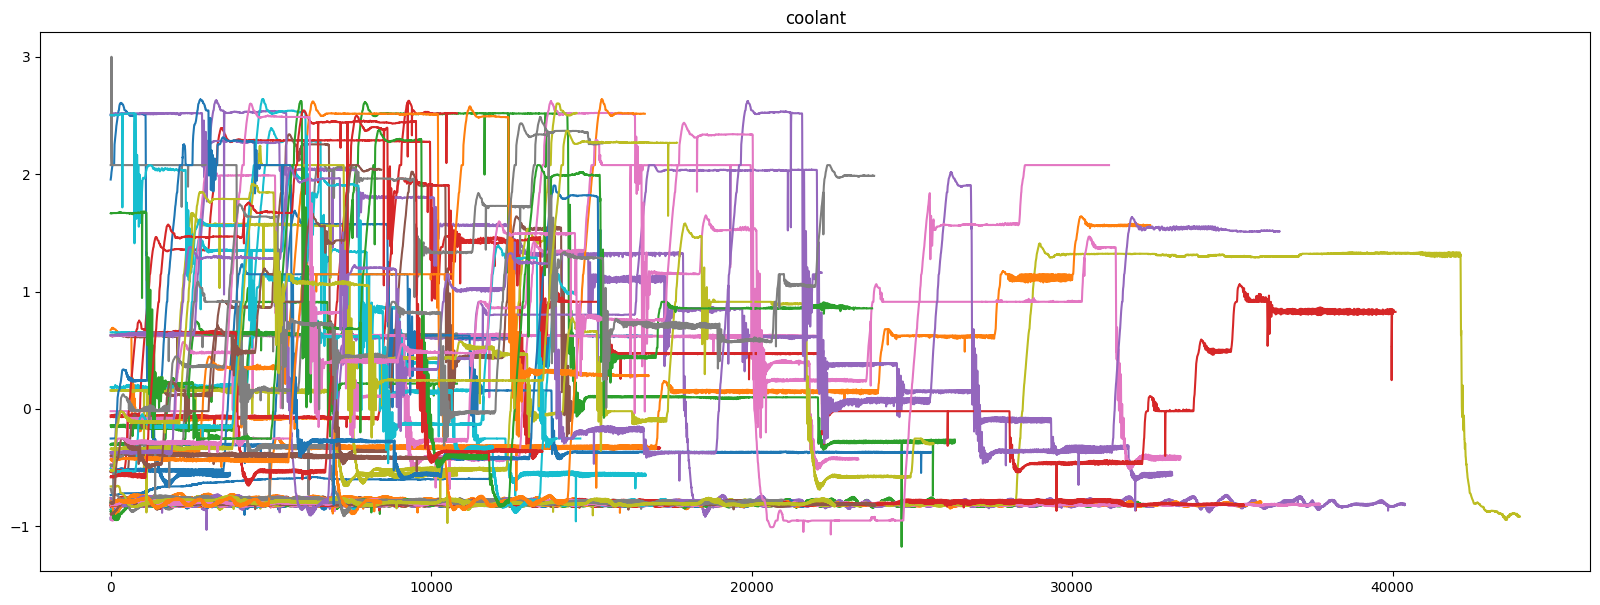

In [38]:
plot_all(data_grouped, 'coolant')

The current and voltages are engine actuators, they are the main controls of the engine, and thus change rapidly (depending on the driving mode)

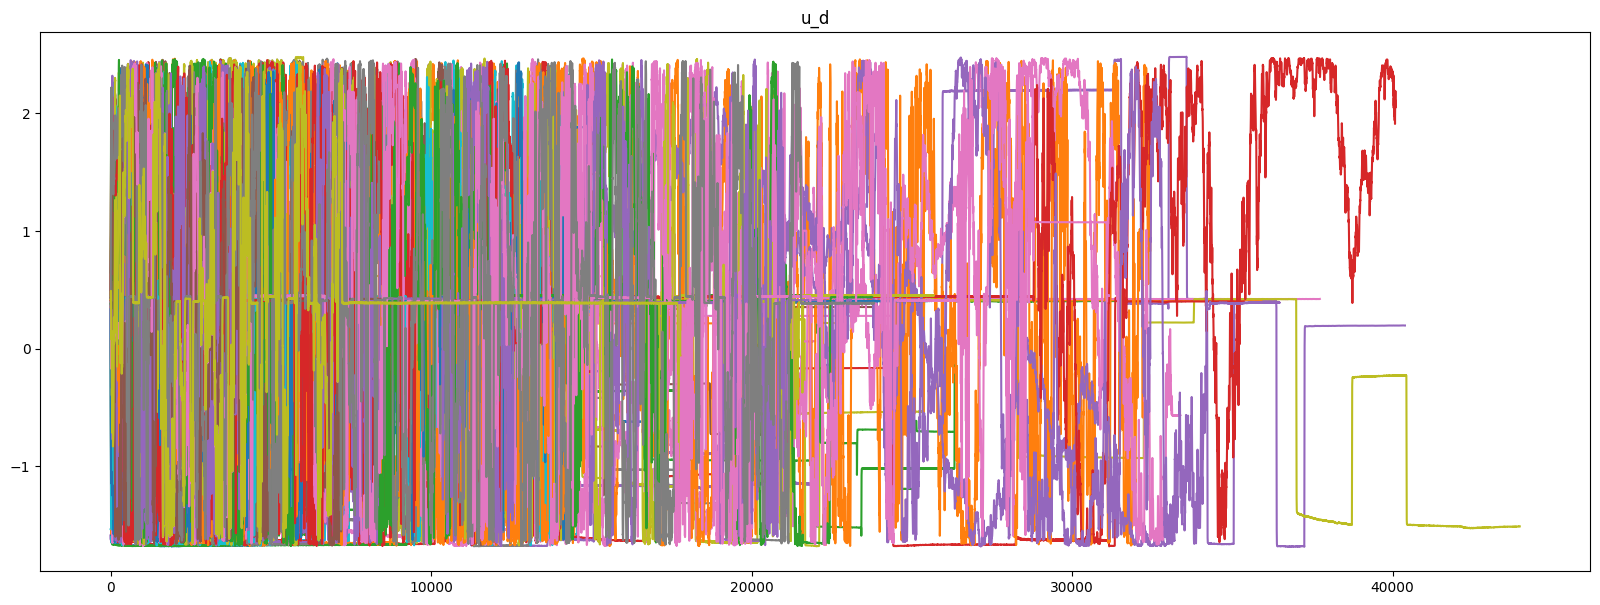

In [39]:
plot_all(data_grouped, 'u_d')

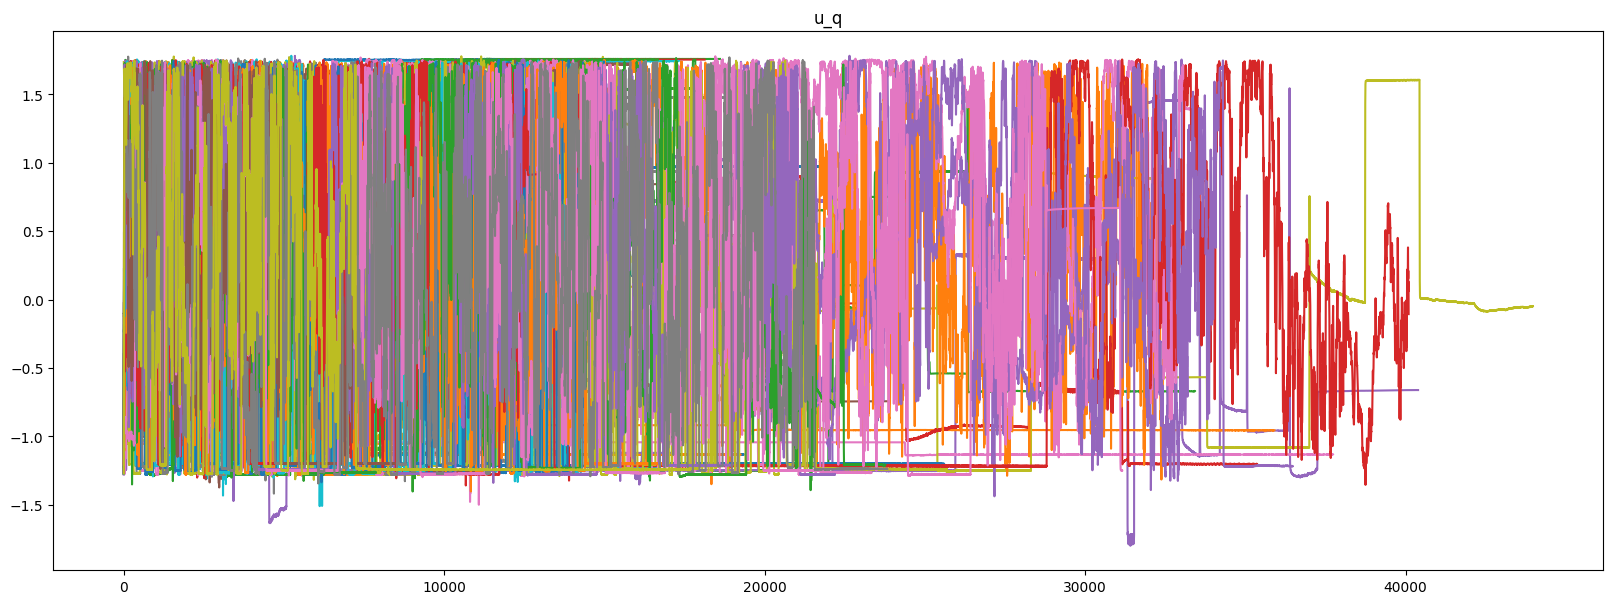

In [40]:
plot_all(data_grouped, 'u_q')

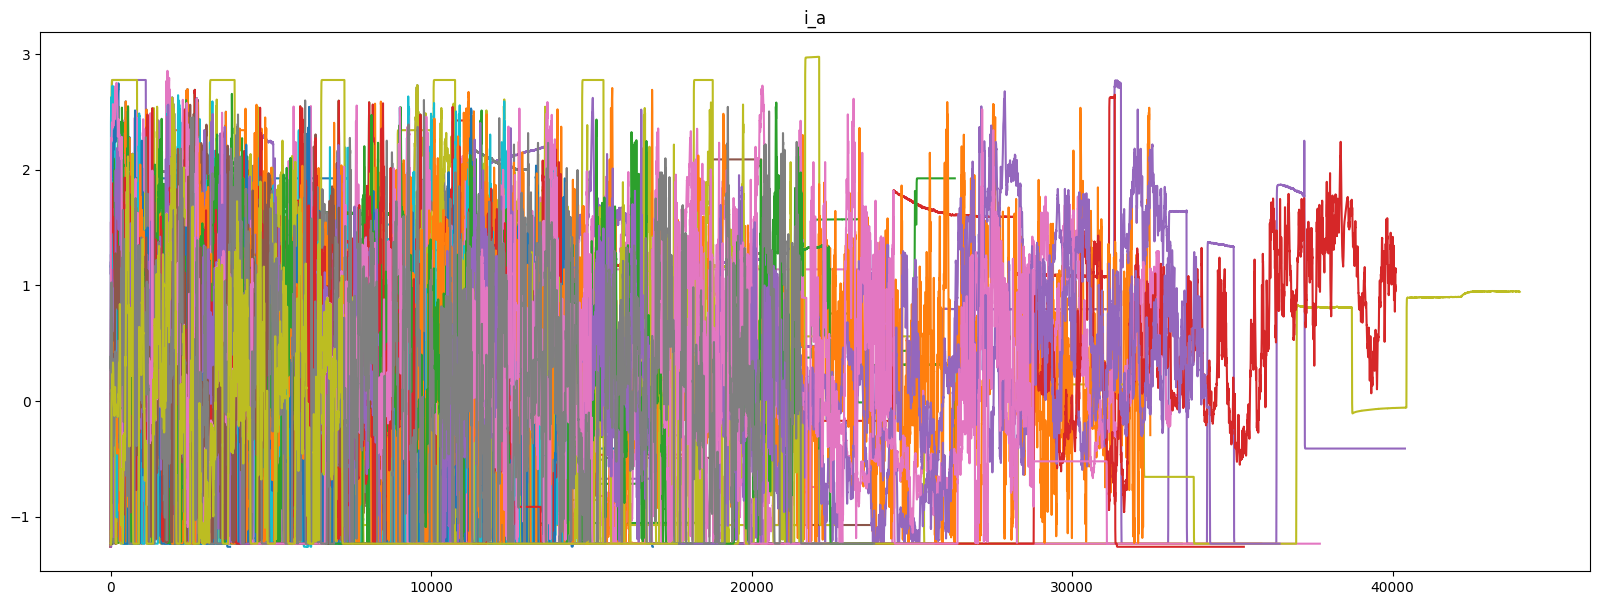

In [41]:
plot_all(data_grouped, 'i_a')

## Preparing samples from series for train / test data

For each "profile_id" let me sample input feature sequences from the time series, each sequence of length "len_sequence" starting start index(=time) "start_index" and ending at "end_index" (end = start + len_sequence - 1). Then I also add the values of output features (having "end_index" as index) that the newly obtained sequence of input features leads up to 

First I split the indices inside each "profile_id" group into ~80% training set indices, and ~20% test set indices. Then I generate sequences of length "len_sequence" (some sequences will not be generated because "end_index" goes over the limit: the number of such sequences depends on "len_sequence" and on the length of the "profile_id" measurement, but for "len_sequence <= 128" it is relatively small) 

IMPORTANT: "len_sequence" is a hyperparameter for our model

In [42]:
#
# helper function for windowing one "profile_id" group
#
def generate_sequences(group_df, indices, len_sequence=128):
    
    data_series = []
    
    len_group_df = len(group_df)
    
    for start_index in indices:
        
        end_index = start_index + len_sequence - 1
        
        if end_index >= len_group_df:
            continue

        # len_features, len_output = len(features), len(output)
        # series of input values :: shape (len_sequence, len_features)
        X_series = group_df.loc[start_index : end_index, features].values
        # output values :: shape (len_output,)
        y_series = group_df.loc[end_index, output].values

        # pairing them up
        data_series.append( [X_series, y_series] )
    
    return data_series
#
# generating sequences by windowing with window width = len_sequence, shift = len_shift from each "profile_id" group
# generating train / test split with given "test_size" (0 to 1) test set
#
def generate_train_test_sequences(data_grouped, len_sequence=128, len_shift=16, test_size=0.2):
    
    #
    data_series_train = []
    data_series_test  = []
    
    # sampling for each group separately
    for group_id, group_df in data_grouped.items():
        
        # verbose
        print('Preparing sequences for group {}'.format(group_id))
        
        # re-index each group from 0 onwards
        index = np.arange(len(group_df))
        group_df.index = index
        
        # in each group split the train and test temiseries windows, and store the sequences separately
        index_train, index_test = train_test_split(index[::len_shift], test_size=test_size) 
        
        # verbose
        print('Train sequences: {}; test sequences {} ...'.format(len(index_train), len(index_test)))
        
        data_series_train.extend( generate_sequences(group_df, index_train, len_sequence=len_sequence) )
        
        data_series_test.extend( generate_sequences(group_df, index_test, len_sequence=len_sequence) )
        
    # splitting the paired (input series, value) into two respective arrays
    X_train, y_train = zip(*data_series_train)
    X_train, y_train = np.array(X_train), np.array(y_train)
        
    X_test, y_test = zip(*data_series_test)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    # verbose
    print('Train / test data generated. Sequence length is {}.'.format(len_sequence))
    print('Train / test split is {} : {}'.format(1-test_size, test_size))
    
    return X_train, X_test, y_train, y_test

## Model architecture

Input layer for sequences of length "len_sequence", each sequence term containing "len_features" input feature values, followed by a simple convolutional autoencoder for smoothing / denoising, followed by 8 relatively small LSTM layers, and then by a dense Output layer for "len_output" values

In [43]:
def model_compile(len_sequence=128, len_features=5, len_output=6):
    ######################
    # Defining the model #
    ######################
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=(len_sequence, len_features)),
        # Convolutional autoencoder
        tf.keras.layers.Conv1D(64, kernel_size=4, padding='same', activation='relu'),
        tf.keras.layers.AveragePooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=4, padding='same', activation='relu'),
        tf.keras.layers.AveragePooling1D(2),
        tf.keras.layers.Conv1DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv1DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'),
        # Stack of LSTM layers
        tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True),
        tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True),
        tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True),
        tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True),
        tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True),
        tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True),
        tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True),
        tf.keras.layers.LSTM(32, activation='tanh', return_sequences=False),
        # Ouput layer
        tf.keras.layers.Dense(len_output, activation='linear')
    ])
    #######################
    # Compiling the model #
    #######################
    model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])

    # verbose
    model.summary()

    return model

## Training the model

I train the model for several values of the hyperparameter "len_sequence" : [16, 32, 64, 128]. The main intuition is that a longer sample allows to detect from which "profile_id" it comes, and thus predict with higher precision 

One may add "len_sequence=256" to the list above, but then the model trains much slower, and does not give any advantage of lower loss. I do not include it this value so that the notebook runs entirely within some reasonbale time (30-40 minutes on my computer)

In [44]:
#
# Maximum of training epochs, batch size for training,
# and shift for time series window (to skip some intervals and sparcify the data)
#
max_n_epochs = 32
batch_size = 256
#

In [45]:
#
# Initializing models container
#
models = []
#
# Trying different hyperparameter values
#
for len_sequence in [16,32,64,128]:
    #
    # Data for training / testing
    #
    len_features=len(features)
    len_output=len(output)
    #
    print("Preparing data for sequence length {}".format(len_sequence))
    #
    len_shift = len_sequence//4 # give consecutive windows 75% overlap, so that we do not produce too many
                                # sequences for training / testing
    #
    X_train, X_test, y_train, y_test = generate_train_test_sequences(data_grouped, len_sequence=len_sequence, \
                                                                     len_shift=len_shift, test_size=0.2)
    #
    # Compiling model
    #
    print("Compiling the model")
    #
    model = model_compile(len_sequence, len_features, len_output)
    #
    # Training model
    #
    # Callback and checkpoint to pick best model (avoid overfitting and stalling)
    #
    # Criteria for early stopping: from each epoch allow two more epochs without improvement, 
    # and if val_loss starts increasing, execute early stopping
    #
    # Then restore the best model from the latest checkpoint
    #
    print("Started training with maximum {} epochs".format(max_n_epochs))
    #
    #
    # callback saving the best model re. validation loss (mse)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min', verbose=1)
    checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_tmp_{}.h5'.format(len_sequence), \
                                                    monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    #
    # training with test / validation split 80% : 20%
    history = model.fit(X_train, y_train, epochs=max_n_epochs, batch_size=batch_size, validation_split=0.2, \
                                                         callbacks=[callback, checkpoint], verbose=1)
    #
    # loading the best model back
    model = tf.keras.models.load_model('best_model_tmp_{}.h5'.format(len_sequence))
    #
    print("Evaluating best model ...")
    evals = model.evaluate(X_test, y_test)
    evals = list(zip(model.metrics_names, evals))
    #
    print("Obtaining predictions ...")
    y_hat = model.predict(X_test)
    #
    # Storing the model
    #
    models += [(len_sequence, model, history, evals, y_test, y_hat)]
    #

Preparing data for sequence length 16
Preparing sequences for group 2
Train sequences: 3872; test sequences 968 ...
Preparing sequences for group 3
Train sequences: 3849; test sequences 963 ...
Preparing sequences for group 4
Train sequences: 6684; test sequences 1672 ...
Preparing sequences for group 5
Train sequences: 2957; test sequences 740 ...
Preparing sequences for group 6
Train sequences: 8077; test sequences 2020 ...
Preparing sequences for group 7
Train sequences: 2930; test sequences 733 ...
Preparing sequences for group 8
Train sequences: 3752; test sequences 938 ...
Preparing sequences for group 9
Train sequences: 4067; test sequences 1017 ...
Preparing sequences for group 10
Train sequences: 3051; test sequences 763 ...
Preparing sequences for group 11
Train sequences: 1577; test sequences 395 ...
Preparing sequences for group 12
Train sequences: 4388; test sequences 1098 ...
Preparing sequences for group 13
Train sequences: 7181; test sequences 1796 ...
Preparing sequenc

2023-05-23 21:35:56.115684: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-23 21:35:56.118632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 64)            1344      
                                                                 
 average_pooling1d (AverageP  (None, 8, 64)            0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 64)             16448     
                                                                 
 average_pooling1d_1 (Averag  (None, 4, 64)            0         
 ePooling1D)                                                     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 8, 64)            16448     
 nspose)                                                         
                                                        

2023-05-23 21:35:59.466306: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/32


2023-05-23 21:36:04.859635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:36:05.872637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:36:06.221113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:36:06.271540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:36:06.317970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:36:06.361580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:36:06.403164: I tensorflow/core/grappler/optimizers/cust

832/832 [==============================] - ETA: 0s - loss: 0.2405 - mse: 0.2405 - mae: 0.3403

2023-05-23 21:37:09.816893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:37:10.240032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:37:10.342652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:37:10.409966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:37:10.472898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:37:10.524142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:37:10.622911: I tensorflow/core/grappler/optimizers/cust


Epoch 1: val_loss improved from inf to 0.29322, saving model to best_model_tmp_16.h5
832/832 [==============================] - 77s 82ms/step - loss: 0.2405 - mse: 0.2405 - mae: 0.3403 - val_loss: 0.2932 - val_mse: 0.2932 - val_mae: 0.4034
Epoch 2/32
832/832 [==============================] - ETA: 0s - loss: 0.1288 - mse: 0.1288 - mae: 0.2342
Epoch 2: val_loss improved from 0.29322 to 0.20363, saving model to best_model_tmp_16.h5
832/832 [==============================] - 56s 67ms/step - loss: 0.1288 - mse: 0.1288 - mae: 0.2342 - val_loss: 0.2036 - val_mse: 0.2036 - val_mae: 0.3285
Epoch 3/32
832/832 [==============================] - ETA: 0s - loss: 0.1085 - mse: 0.1085 - mae: 0.2114
Epoch 3: val_loss did not improve from 0.20363
832/832 [==============================] - 59s 71ms/step - loss: 0.1085 - mse: 0.1085 - mae: 0.2114 - val_loss: 0.2103 - val_mse: 0.2103 - val_mae: 0.3356
Epoch 4/32
832/832 [==============================] - ETA: 0s - loss: 0.0996 - mse: 0.0996 - mae: 0.200

2023-05-23 21:47:13.069488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:47:14.414358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:47:15.195446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:47:15.334498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:47:15.465682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:47:15.579920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:47:15.758068: I tensorflow/core/grappler/optimizers/cust

2080/2080 [==============================] - 64s 26ms/step - loss: 0.1068 - mse: 0.1068 - mae: 0.2076
Obtaining predictions ...


2023-05-23 21:48:12.934185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:48:13.286698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:48:13.467740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:48:13.585997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:48:13.770891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:48:13.945988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:48:14.021499: I tensorflow/core/grappler/optimizers/cust

   2/2080 [..............................] - ETA: 2:39   

2023-05-23 21:48:14.214375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2080/2080 [==============================] - 49s 22ms/step
Preparing data for sequence length 32
Preparing sequences for group 2
Train sequences: 1936; test sequences 484 ...
Preparing sequences for group 3
Train sequences: 1924; test sequences 482 ...
Preparing sequences for group 4
Train sequences: 3342; test sequences 836 ...
Preparing sequences for group 5
Train sequences: 1479; test sequences 370 ...
Preparing sequences for group 6
Train sequences: 4039; test sequences 1010 ...
Preparing sequences for group 7
Train sequences: 1465; test sequences 367 ...
Preparing sequences for group 8
Train sequences: 1876; test sequences 469 ...
Preparing sequences for group 9
Train sequences: 2033; test sequences 509 ...
Preparing sequences for group 10
Train sequences: 1525; test sequences 382 ...
Preparing sequences for group 11
Train sequences: 788; test sequences 198 ...
Preparing sequences for group 12
Train sequences: 2194; test sequences 549 ...
Preparing sequences for group 13
Train seq

Non-trainable params: 0
_________________________________________________________________
Started training with maximum 32 epochs
Epoch 1/32


2023-05-23 21:50:23.310720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:50:24.427601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:50:24.861273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:50:25.100965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:50:25.673611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:50:25.933445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:50:26.181982: I tensorflow/core/grappler/optimizers/cust

416/416 [==============================] - ETA: 0s - loss: 0.2885 - mse: 0.2885 - mae: 0.3828

2023-05-23 21:51:10.576079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:51:10.968130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:51:11.064351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:51:11.239173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:51:11.390588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:51:11.480303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 21:51:11.571265: I tensorflow/core/grappler/optimizers/cust


Epoch 1: val_loss improved from inf to 0.27239, saving model to best_model_tmp_32.h5
416/416 [==============================] - 58s 112ms/step - loss: 0.2885 - mse: 0.2885 - mae: 0.3828 - val_loss: 0.2724 - val_mse: 0.2724 - val_mae: 0.3831
Epoch 2/32
416/416 [==============================] - ETA: 0s - loss: 0.1366 - mse: 0.1366 - mae: 0.2446
Epoch 2: val_loss improved from 0.27239 to 0.24584, saving model to best_model_tmp_32.h5
416/416 [==============================] - 42s 101ms/step - loss: 0.1366 - mse: 0.1366 - mae: 0.2446 - val_loss: 0.2458 - val_mse: 0.2458 - val_mae: 0.3641
Epoch 3/32
416/416 [==============================] - ETA: 0s - loss: 0.1141 - mse: 0.1141 - mae: 0.2173
Epoch 3: val_loss did not improve from 0.24584
416/416 [==============================] - 37s 87ms/step - loss: 0.1141 - mse: 0.1141 - mae: 0.2173 - val_loss: 0.2574 - val_mse: 0.2574 - val_mae: 0.3653
Epoch 4/32
416/416 [==============================] - ETA: 0s - loss: 0.1040 - mse: 0.1040 - mae: 0.2

2023-05-23 22:01:33.191988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:01:33.935669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:01:34.600978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:01:34.709920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:01:34.878728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:01:35.115149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:01:35.242657: I tensorflow/core/grappler/optimizers/cust

1039/1039 [==============================] - 68s 62ms/step - loss: 0.1018 - mse: 0.1018 - mae: 0.2006
Obtaining predictions ...


2023-05-23 22:02:41.894521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:02:42.346762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:02:42.482046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:02:42.667356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:02:43.152424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:02:43.417671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:02:43.969720: I tensorflow/core/grappler/optimizers/cust

1039/1039 [==============================] - 54s 48ms/step
Preparing data for sequence length 64
Preparing sequences for group 2
Train sequences: 968; test sequences 242 ...
Preparing sequences for group 3
Train sequences: 962; test sequences 241 ...
Preparing sequences for group 4
Train sequences: 1671; test sequences 418 ...
Preparing sequences for group 5
Train sequences: 740; test sequences 185 ...
Preparing sequences for group 6
Train sequences: 2020; test sequences 505 ...
Preparing sequences for group 7
Train sequences: 732; test sequences 184 ...
Preparing sequences for group 8
Train sequences: 938; test sequences 235 ...
Preparing sequences for group 9
Train sequences: 1016; test sequences 255 ...
Preparing sequences for group 10
Train sequences: 763; test sequences 191 ...
Preparing sequences for group 11
Train sequences: 394; test sequences 99 ...
Preparing sequences for group 12
Train sequences: 1097; test sequences 275 ...
Preparing sequences for group 13
Train sequences: 

_________________________________________________________________
Started training with maximum 32 epochs
Epoch 1/32


2023-05-23 22:04:55.897397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:04:58.603547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:04:59.976829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:05:00.497467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:05:01.463961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:05:01.714259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:05:02.110683: I tensorflow/core/grappler/optimizers/cust

208/208 [==============================] - ETA: 0s - loss: 0.3677 - mse: 0.3677 - mae: 0.4400

2023-05-23 22:05:46.931903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:05:47.329072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:05:47.469726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:05:47.636692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:05:47.787829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:05:47.926408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:05:48.040792: I tensorflow/core/grappler/optimizers/cust


Epoch 1: val_loss improved from inf to 0.27986, saving model to best_model_tmp_64.h5
208/208 [==============================] - 72s 204ms/step - loss: 0.3677 - mse: 0.3677 - mae: 0.4400 - val_loss: 0.2799 - val_mse: 0.2799 - val_mae: 0.3903
Epoch 2/32
208/208 [==============================] - ETA: 0s - loss: 0.1454 - mse: 0.1454 - mae: 0.2548
Epoch 2: val_loss improved from 0.27986 to 0.24183, saving model to best_model_tmp_64.h5
208/208 [==============================] - 41s 191ms/step - loss: 0.1454 - mse: 0.1454 - mae: 0.2548 - val_loss: 0.2418 - val_mse: 0.2418 - val_mae: 0.3557
Epoch 3/32
208/208 [==============================] - ETA: 0s - loss: 0.1237 - mse: 0.1237 - mae: 0.2292
Epoch 3: val_loss improved from 0.24183 to 0.22896, saving model to best_model_tmp_64.h5
208/208 [==============================] - 33s 159ms/step - loss: 0.1237 - mse: 0.1237 - mae: 0.2292 - val_loss: 0.2290 - val_mse: 0.2290 - val_mae: 0.3464
Epoch 4/32
208/208 [==============================] - ETA:

208/208 [==============================] - ETA: 0s - loss: 0.0544 - mse: 0.0544 - mae: 0.1435
Epoch 26: val_loss improved from 0.16636 to 0.16018, saving model to best_model_tmp_64.h5
208/208 [==============================] - 39s 188ms/step - loss: 0.0544 - mse: 0.0544 - mae: 0.1435 - val_loss: 0.1602 - val_mse: 0.1602 - val_mae: 0.2844
Epoch 27/32
208/208 [==============================] - ETA: 0s - loss: 0.0542 - mse: 0.0542 - mae: 0.1434
Epoch 27: val_loss did not improve from 0.16018
208/208 [==============================] - 40s 190ms/step - loss: 0.0542 - mse: 0.0542 - mae: 0.1434 - val_loss: 0.1733 - val_mse: 0.1733 - val_mae: 0.2940
Epoch 28/32
208/208 [==============================] - ETA: 0s - loss: 0.0561 - mse: 0.0561 - mae: 0.1459
Epoch 28: val_loss did not improve from 0.16018
208/208 [==============================] - 55s 255ms/step - loss: 0.0561 - mse: 0.0561 - mae: 0.1459 - val_loss: 0.1628 - val_mse: 0.1628 - val_mae: 0.2871
Epoch 29/32
208/208 [===================

2023-05-23 22:25:40.339737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:25:41.788086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:25:43.169916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:25:43.643296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:25:44.371928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:25:44.761017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:25:46.881979: I tensorflow/core/grappler/optimizers/cust

520/520 [==============================] - 61s 87ms/step - loss: 0.0773 - mse: 0.0773 - mae: 0.1748
Obtaining predictions ...


2023-05-23 22:26:39.012603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:26:39.654197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:26:39.857504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:26:40.145282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:26:40.357818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:26:40.479654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:26:40.713110: I tensorflow/core/grappler/optimizers/cust

520/520 [==============================] - 46s 78ms/step
Preparing data for sequence length 128
Preparing sequences for group 2
Train sequences: 484; test sequences 121 ...
Preparing sequences for group 3
Train sequences: 481; test sequences 121 ...
Preparing sequences for group 4
Train sequences: 836; test sequences 209 ...
Preparing sequences for group 5
Train sequences: 370; test sequences 93 ...
Preparing sequences for group 6
Train sequences: 1010; test sequences 253 ...
Preparing sequences for group 7
Train sequences: 366; test sequences 92 ...
Preparing sequences for group 8
Train sequences: 469; test sequences 118 ...
Preparing sequences for group 9
Train sequences: 508; test sequences 128 ...
Preparing sequences for group 10
Train sequences: 381; test sequences 96 ...
Preparing sequences for group 11
Train sequences: 197; test sequences 50 ...
Preparing sequences for group 12
Train sequences: 548; test sequences 138 ...
Preparing sequences for group 13
Train sequences: 898; te

Started training with maximum 32 epochs
Epoch 1/32


2023-05-23 22:27:57.139225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:27:59.042403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:27:59.669741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:28:00.716565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:28:00.987950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:28:01.357724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:28:01.806638: I tensorflow/core/grappler/optimizers/cust

104/104 [==============================] - ETA: 0s - loss: 0.4967 - mse: 0.4967 - mae: 0.5341

2023-05-23 22:28:52.681611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:28:53.118850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:28:53.586180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:28:53.927963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:28:54.274985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:28:54.514475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:28:54.810331: I tensorflow/core/grappler/optimizers/cust


Epoch 1: val_loss improved from inf to 0.42670, saving model to best_model_tmp_128.h5
104/104 [==============================] - 78s 474ms/step - loss: 0.4967 - mse: 0.4967 - mae: 0.5341 - val_loss: 0.4267 - val_mse: 0.4267 - val_mae: 0.4881
Epoch 2/32
104/104 [==============================] - ETA: 0s - loss: 0.2340 - mse: 0.2340 - mae: 0.3425
Epoch 2: val_loss improved from 0.42670 to 0.28211, saving model to best_model_tmp_128.h5
104/104 [==============================] - 46s 401ms/step - loss: 0.2340 - mse: 0.2340 - mae: 0.3425 - val_loss: 0.2821 - val_mse: 0.2821 - val_mae: 0.3937
Epoch 3/32
104/104 [==============================] - ETA: 0s - loss: 0.1502 - mse: 0.1502 - mae: 0.2645
Epoch 3: val_loss improved from 0.28211 to 0.25440, saving model to best_model_tmp_128.h5
104/104 [==============================] - 39s 366ms/step - loss: 0.1502 - mse: 0.1502 - mae: 0.2645 - val_loss: 0.2544 - val_mse: 0.2544 - val_mae: 0.3750
Epoch 4/32
104/104 [==============================] - E

104/104 [==============================] - ETA: 0s - loss: 0.0628 - mse: 0.0628 - mae: 0.1618
Epoch 26: val_loss improved from 0.15826 to 0.15510, saving model to best_model_tmp_128.h5
104/104 [==============================] - 50s 483ms/step - loss: 0.0628 - mse: 0.0628 - mae: 0.1618 - val_loss: 0.1551 - val_mse: 0.1551 - val_mae: 0.2849
Epoch 27/32
104/104 [==============================] - ETA: 0s - loss: 0.0601 - mse: 0.0601 - mae: 0.1568
Epoch 27: val_loss did not improve from 0.15510
104/104 [==============================] - 29s 276ms/step - loss: 0.0601 - mse: 0.0601 - mae: 0.1568 - val_loss: 0.1643 - val_mse: 0.1643 - val_mae: 0.2913
Epoch 28/32
104/104 [==============================] - ETA: 0s - loss: 0.0577 - mse: 0.0577 - mae: 0.1534
Epoch 28: val_loss did not improve from 0.15510
104/104 [==============================] - 29s 278ms/step - loss: 0.0577 - mse: 0.0577 - mae: 0.1534 - val_loss: 0.1651 - val_mse: 0.1651 - val_mae: 0.2938
Epoch 29/32
104/104 [==================

2023-05-23 22:46:53.106460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:46:54.738334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:46:56.551643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:46:56.978359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:46:57.243880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:46:57.450454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:46:57.727687: I tensorflow/core/grappler/optimizers/cust

260/260 [==============================] - 55s 138ms/step - loss: 0.0790 - mse: 0.0790 - mae: 0.1842
Obtaining predictions ...


2023-05-23 22:47:36.748497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:47:37.139088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:47:37.503792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:47:37.801579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:47:38.024604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:47:38.297090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-23 22:47:38.529022: I tensorflow/core/grappler/optimizers/cust

260/260 [==============================] - 41s 143ms/step


## Results

In [46]:
#
# Function for plotting the graphs
#
def plot_model_training_eval(len_sequence, model, history, evals, y_test, y_hat):
    
    #
    # Scaling the values back and creating data frames
    #
    df_y_test = pd.DataFrame(scaler_y.inverse_transform(y_test), columns=output)
    df_y_hat = pd.DataFrame(scaler_y.inverse_transform(y_hat), columns=output)
    
    #
    # Figure layout
    #
    fig = plt.figure(figsize=(15, 15), layout="tight")
    spec = fig.add_gridspec(3, 3)

    ax0 = fig.add_subplot(spec[0, :])
    axes = []

    for i in range(1,3):
        for j in range(3):
            axes += [fig.add_subplot(spec[i,j])]

    ax0.plot(history.history['loss'])
    ax0.plot(history.history['val_loss'])
    ax0.set_title(f'Training History \nBest {evals[1][0]} : {evals[1][1]:.2} \nBest {evals[2][0]} : {evals[2][1]:.2}')
    ax0.set_xlabel('Epoch')
    ax0.set_ylabel('MSE')
    ax0.legend(['Training','Validation']);
    
    # Defining colors (possibly repeating if we decide to use more output features)

    cols = ['r','g','b','c','m','y','k']*(1+len(output)//7)
    
    #
    # Plotting R^2, for predicted values vs ground truth for each output feature separately
    #
    for out, ax, col in zip(output, axes, cols):
                
        val_ground_truth = df_y_test.loc[:, out]
        val_predicted = df_y_hat.loc[:, out]
        
        r2 = r2_score(val_ground_truth, val_predicted)
        
        label = f'R2 score:{r2:.2}'
        ax.set_xlabel(out+' predicted')
        ax.set_ylabel(out+' ground truth')
        sns.scatterplot(x=val_predicted, y=val_ground_truth, ax=ax, color=col, alpha=0.5, label=label)


    fig.suptitle('Model for sequence length {}'.format(len_sequence));

Below I plot the training history for each model and also the ground truth vs predicted values of each output feature together with R^2 score and relative RMSE (of y_test vs y_hat)

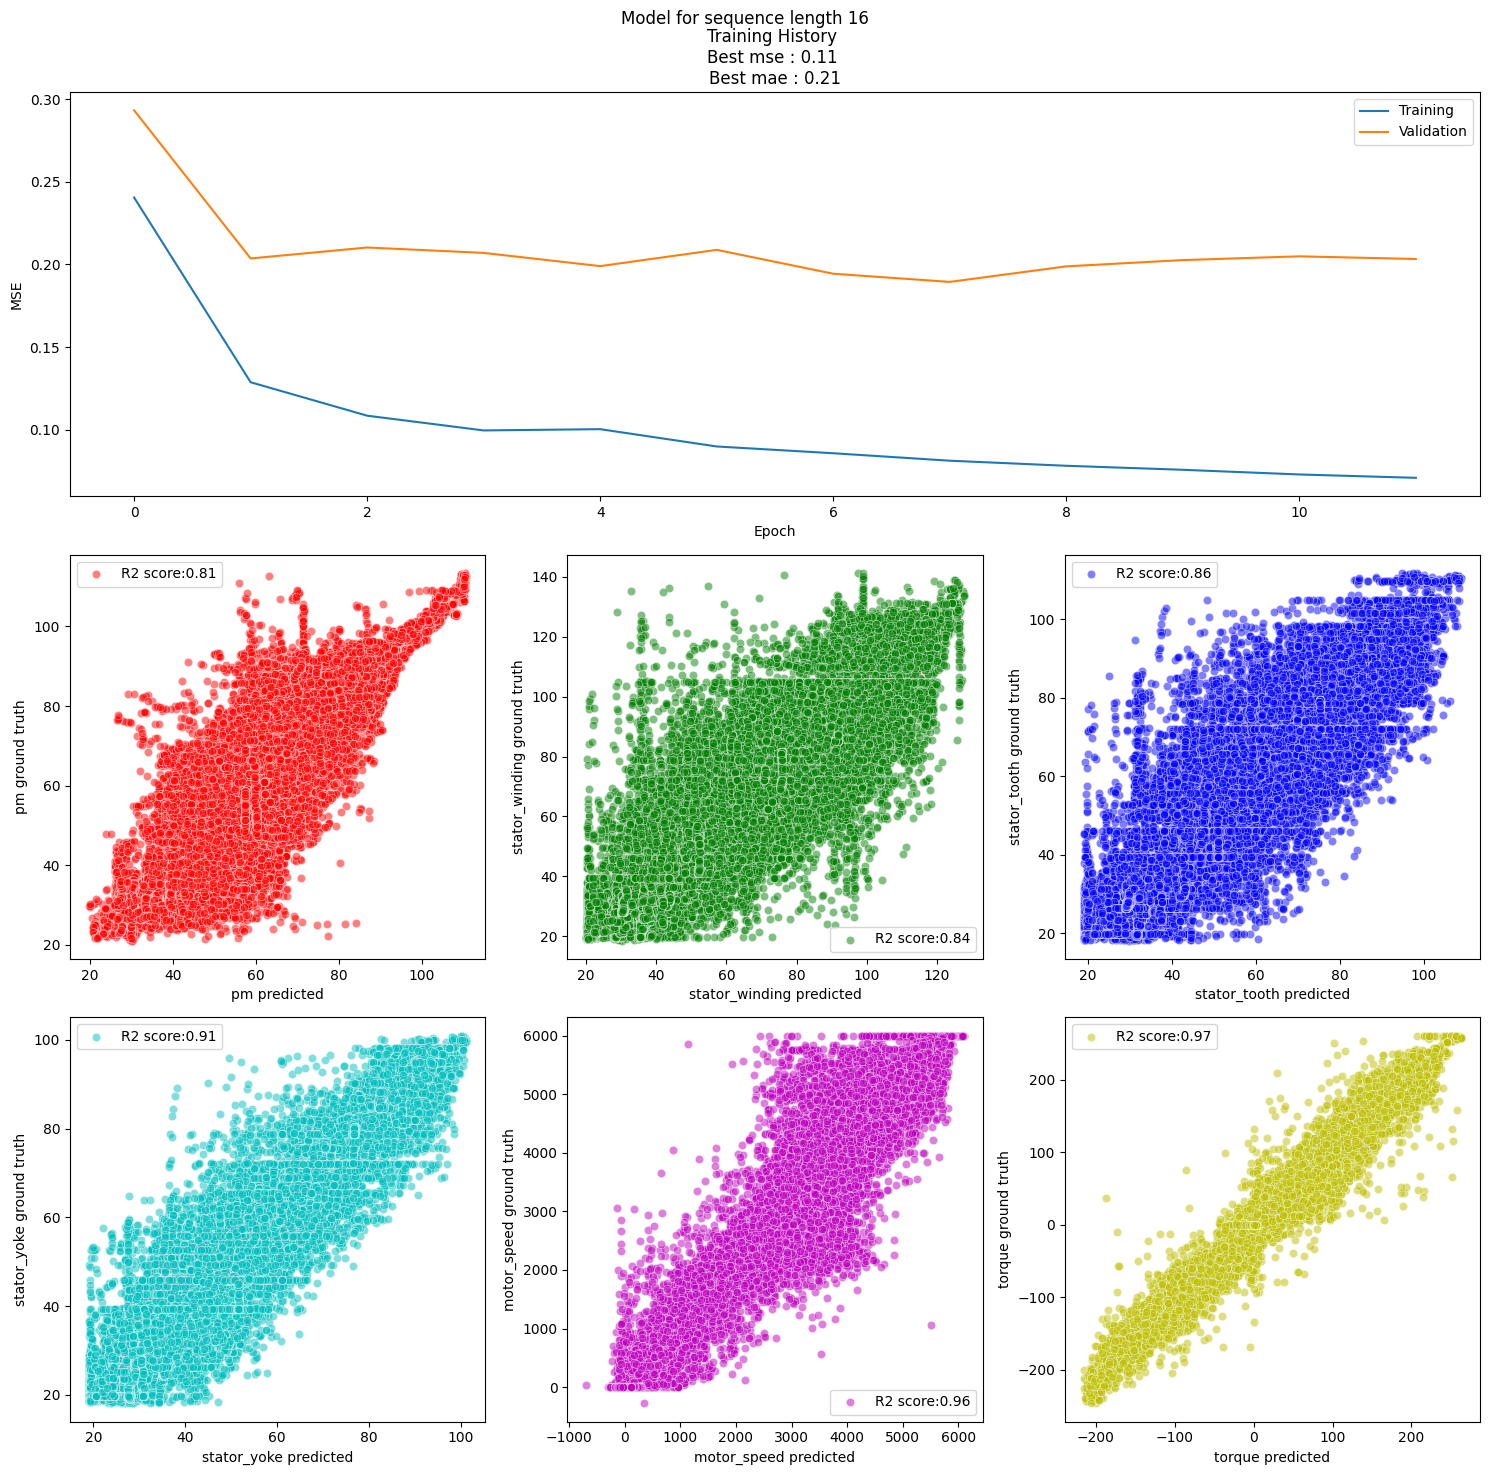

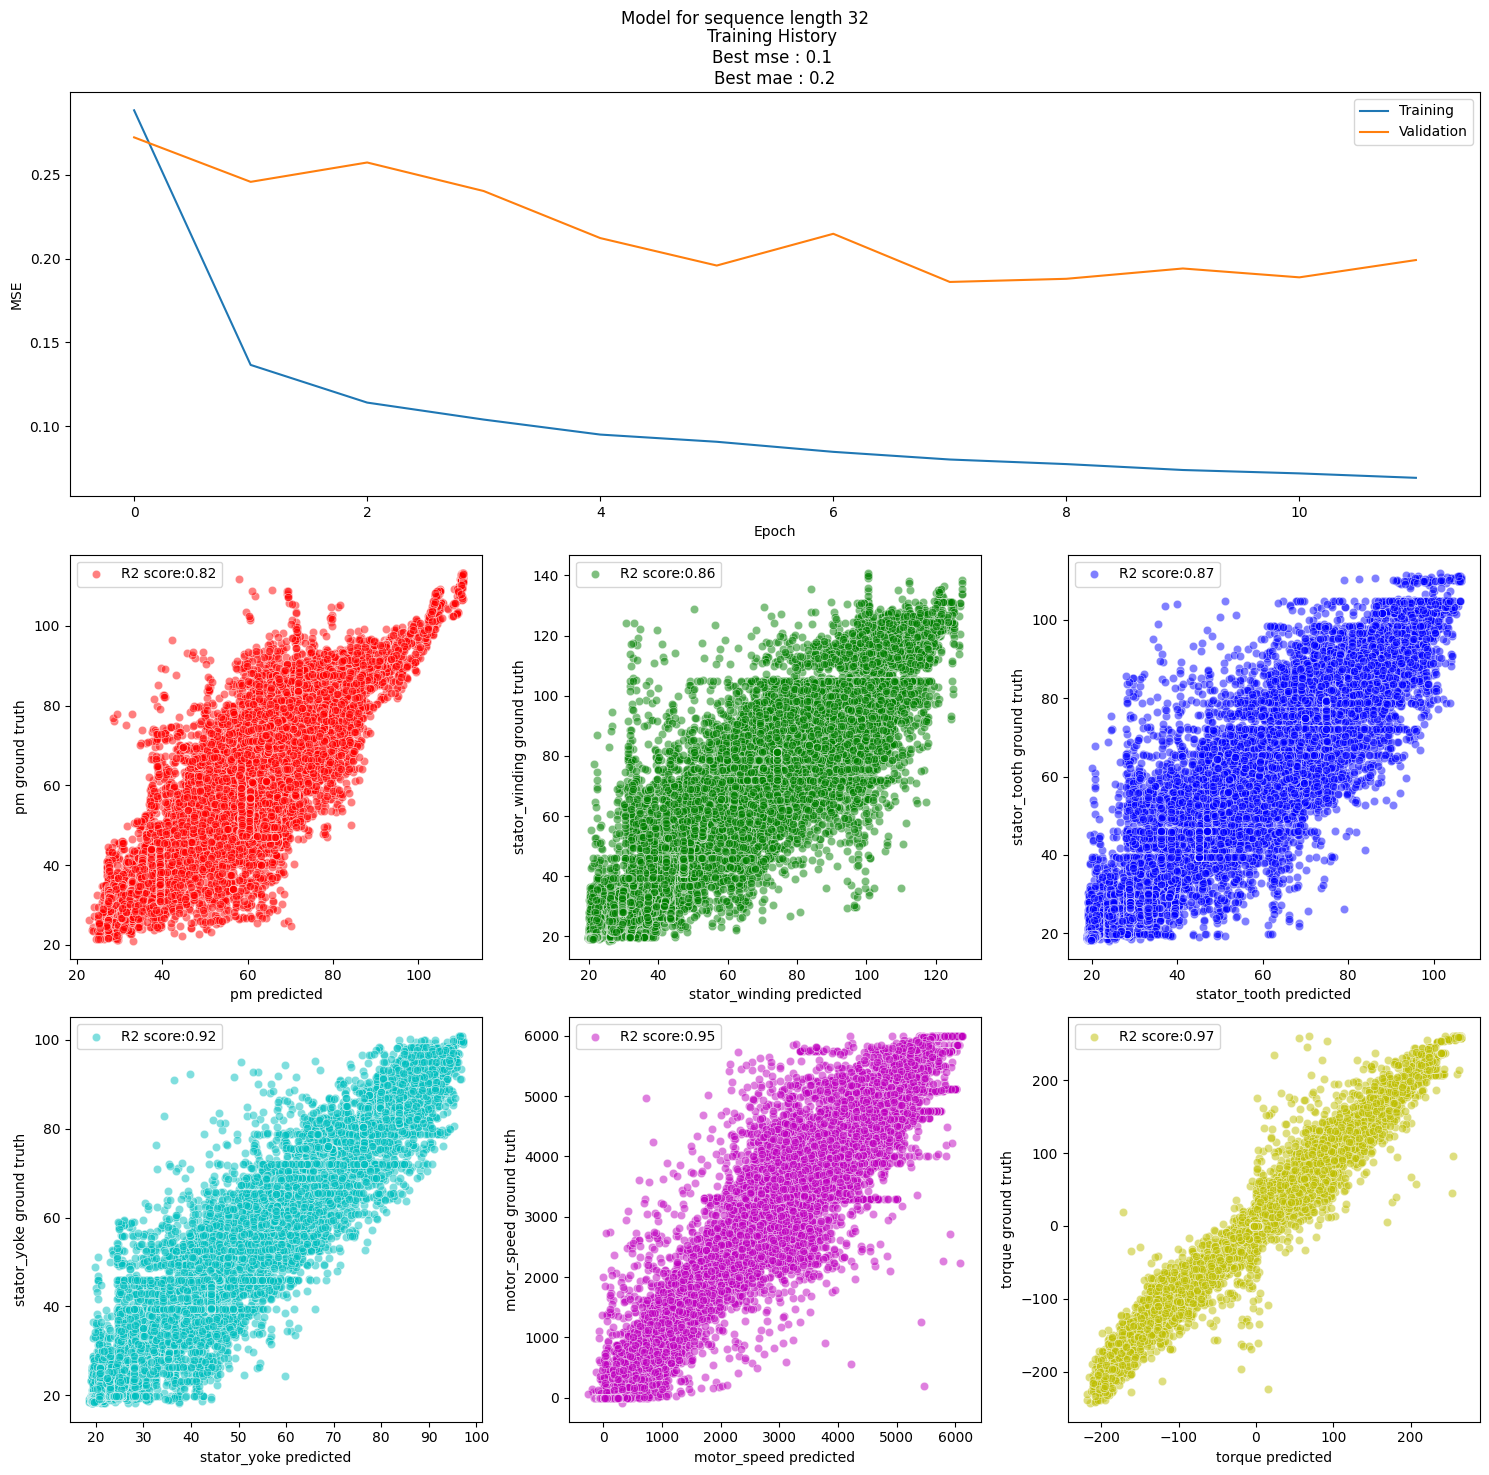

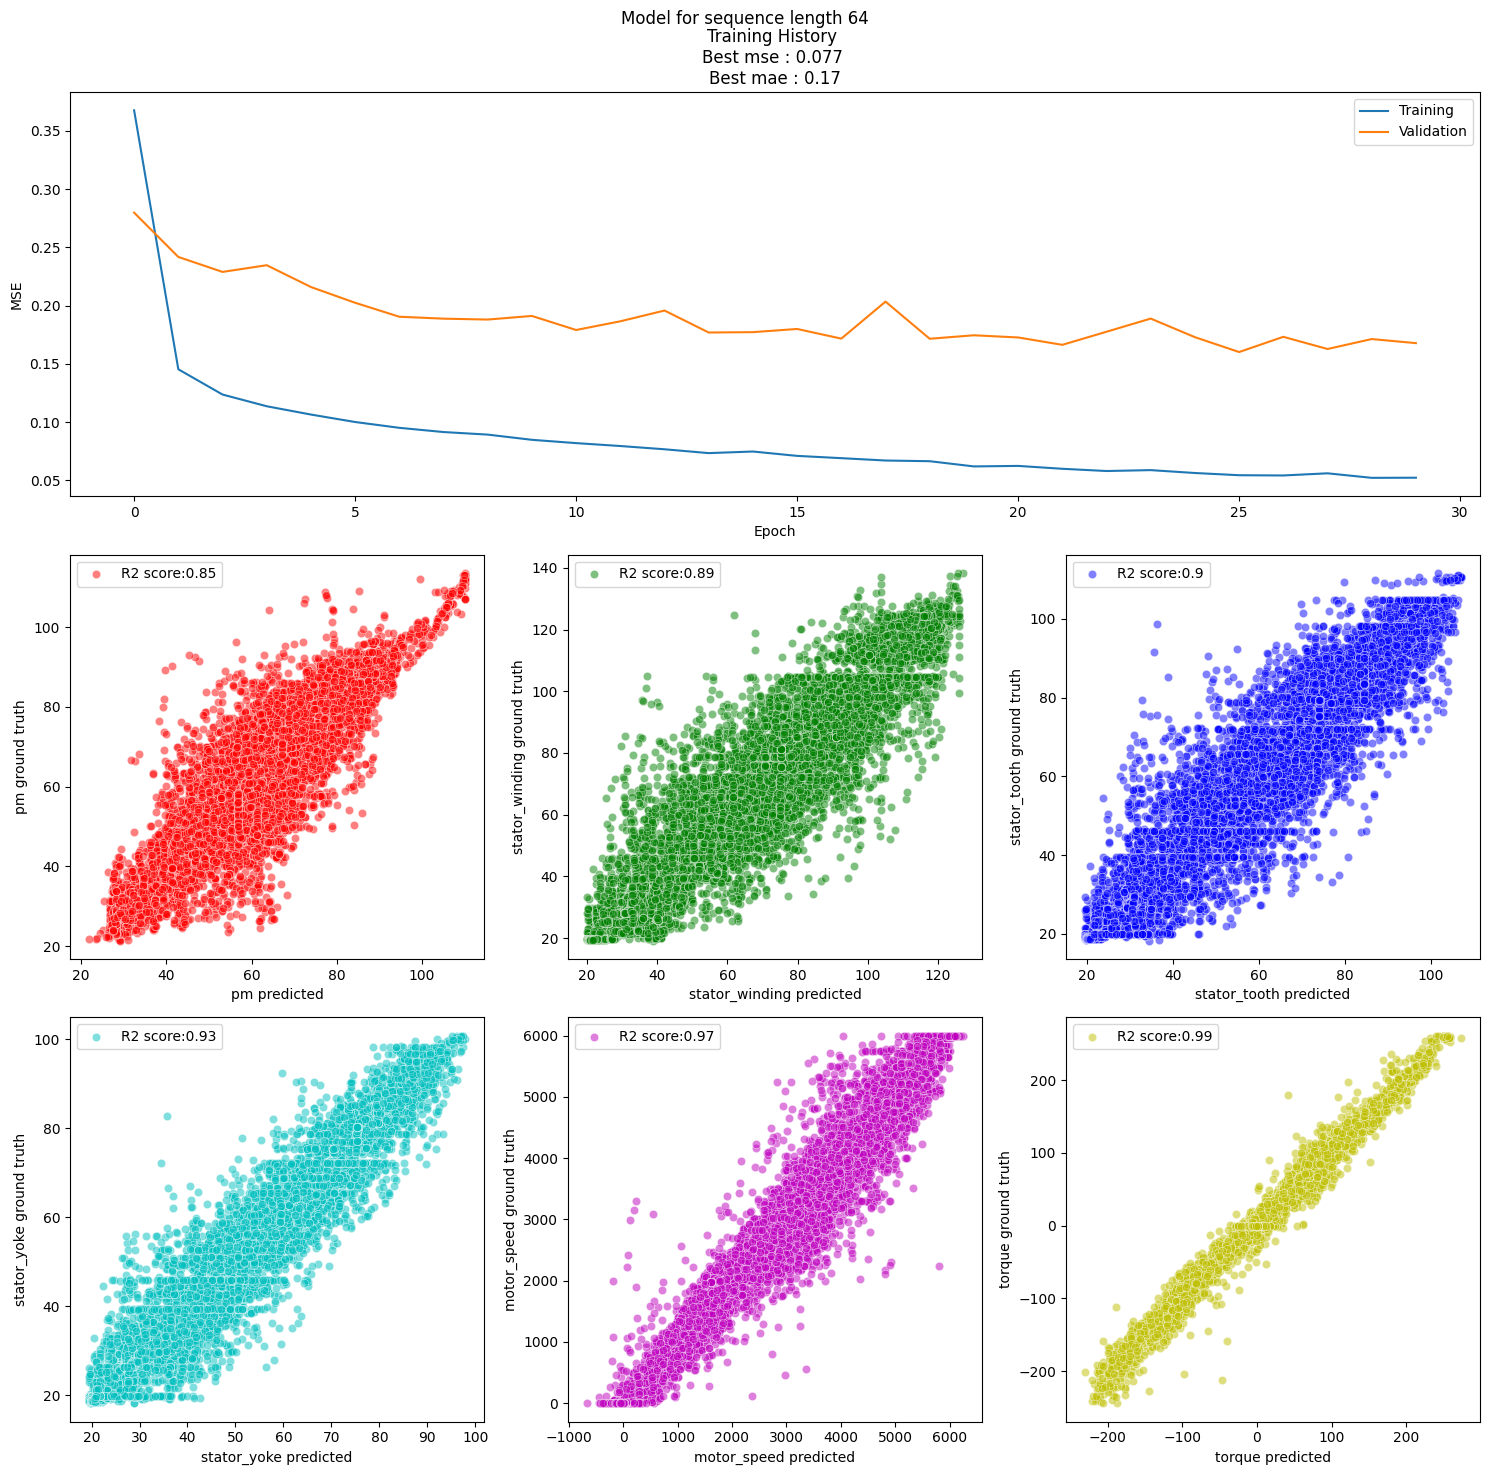

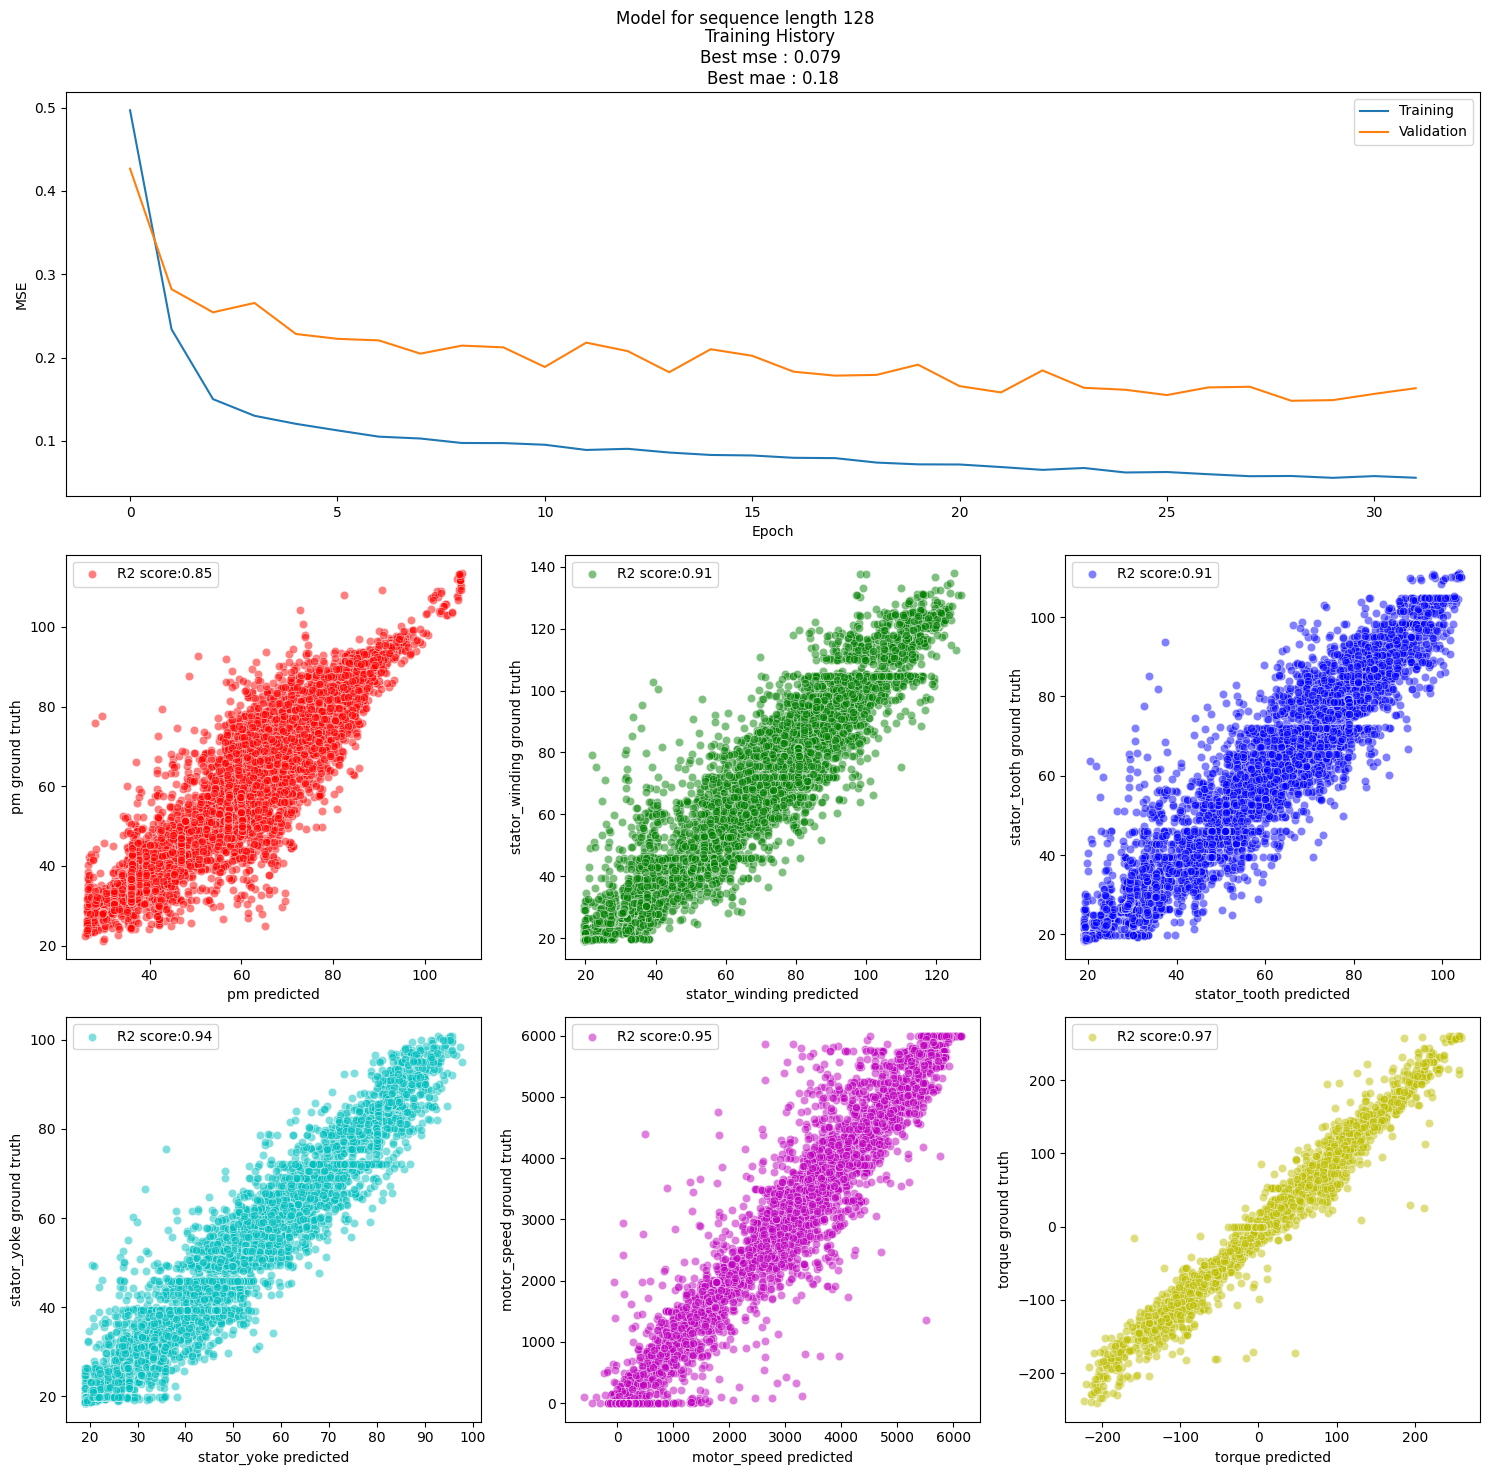

In [47]:
for len_sequence, model, history, evals, y_test, y_hat in models:
    plot_model_training_eval(len_sequence, model, history, evals, y_test, y_hat)

I can also add some other metrics such as MSE, RMSE, but they likely won't say as much: the features above are heterogeneous, so we will get some numbers, and that will be it. We already have some loss coming from trainig the model. Now, we want to check the goodness-of-fit for each of the features, and I posit that seeing R^2 is (mostly) enough.

It also seems that the optimal input sequence length (time series window) is 64. There is not enough information coming from shorter sequences (e.g. 16, 32), thus using them gives less accuracy. However I do not gain more accuracy for longer ones (e.g. 128) while the training takes longer: apparently at this point the model becomes overwhelmed with information, and cannot learn to predict so well either. 